In [288]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams['figure.figsize'] = (10, 5)
import pandas as pd
import math as m
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, accuracy_score,r2_score
import itertools
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor  # Use XGBClassifier for classification tasks

In [289]:
data = "processed_dataset.csv"
# processed_dataset_powerprod.csv       Classifies outliers, this means additional features in model, with the goal of fitting the model better to power production
# processed_dataset.csv      This file deletes all outliers, max pre-processing, deletes cp values etc

DATA17 = "data/raw/Onsite-MetMast-SCADA-data-2017.xlsx"
DATAScada17 = "data/raw/Wind-Turbine-SCADA-signals-2017_0.xlsx"

data17 = pd.read_excel(DATA17, engine='openpyxl')
datascada17= pd.read_excel(DATAScada17, engine="openpyxl")

merged_df17 = pd.merge(datascada17, data17, on="Timestamp", how="inner")

In [290]:
merged_df = pd.read_csv(data)

the csv file is a preprocessed file, which was processed using rules from analysis of the power production

scada data from 2017 needs to be preprocessed as well:
- t07 turbine should only be evaluated (see below)

In [291]:
#t07 is selected
merged_df17 = merged_df17[merged_df17["Turbine_ID"] == "T07"]

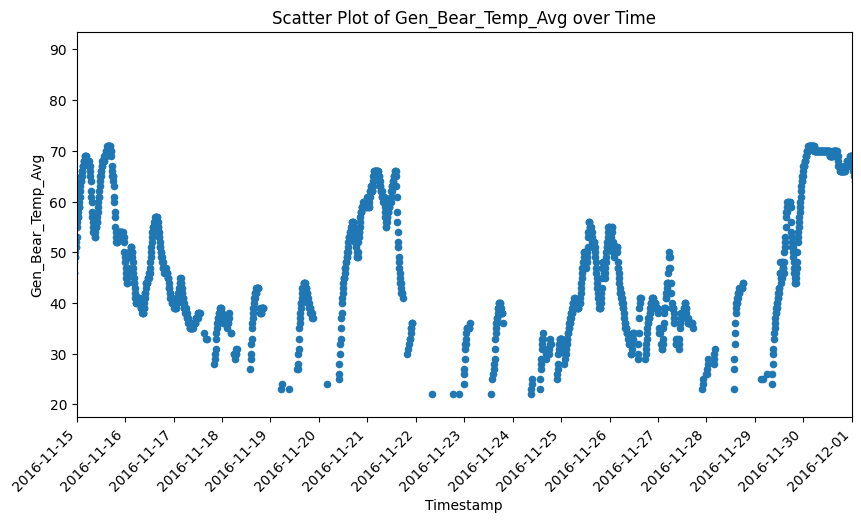

In [292]:
# plotting some data to look for outliers and anomalties in the data itself. Visualize the data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#for i in merged_df:
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])

ax = merged_df.plot.scatter(x="Timestamp", y="Gen_Bear_Temp_Avg")

# Customize the format of the timestamp on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Optionally, set the locator for more control over tick placement
ax.xaxis.set_major_locator(mdates.DayLocator())  # You can adjust the locator based on your data frequency

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
#Define interval for data
plt.xlim(pd.Timestamp('2016-11-15'), pd.Timestamp('2016-12-01'))

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Gen_Bear_Temp_Avg')
plt.title('Scatter Plot of Gen_Bear_Temp_Avg over Time')

# Show the plot
plt.show()


## Custom features

In [293]:
# creating data columns for the xgboost regressor

# Air density

# acceleration last x seconds

# Can we implement average speed for the last 30 minutes

# C_p?

# tip speed ratio

# Angle of blades

# Wind direction

# wind speed modified for distributed wind speed on diameter of blade

Air density 

In [294]:

# https://wahiduddin.net/calc/density_altitude.htm

# def Calculate_Air_Density(temperature, pressure, humidity):
def Calculate_Air_Density(data_dict={}):

	temperature =  data_dict.get('temperature', 0)
	pressure = data_dict.get('pressure', 0) * 100
	humidity = data_dict.get('humidity', 0)

#	print (f'temperature = {temperature}, pressure = {pressure}, humidity = {humidity}')
#	print ('')

	# Constants
	R_specific_dry_air = 287.05  # Specific gas constant for dry air in J/(kg·K)

	# Convert temperature to Kelvin
	temperature_k = temperature + 273.15

	# Calculate water vapor pressure
	e_s = 6.1078 * 10 ** ((7.5 * temperature) / (237.3 + temperature))  # Saturation vapor pressure (Tetens' Formula)
	e = humidity * e_s / 100.0  # Vapor pressure

	# Calculate specific humidity
	q = 0.622 * e / (pressure - 0.378 * e)

	# Calculate air density
	rho_dry_air = pressure / (R_specific_dry_air * temperature_k)
	rho_water_vapor = q / temperature_k

	# Total air density
	rho_air = rho_dry_air + rho_water_vapor

	return rho_air


In [295]:


# Define gas constants for dry air and water vapor in J/(kg*K)
R_d = 287.058  
R_v = 461.495  

# Convert temperature to Kelvin and pressure to Pascals
merged_df["T"] = merged_df["Amb_Temp_Avg"] + 273.15         # Temperature in Kelvin
merged_df["p"] = merged_df["Avg_Pressure"] * 100              # Total pressure in Pa

# Calculate saturation vapor pressure (in Pa) using the Magnus formula
# 6.112 hPa is converted to Pa by multiplying by 100
merged_df["e_s"] = 6.112 * np.exp((17.67 * merged_df["Amb_Temp_Avg"]) / (merged_df["Amb_Temp_Avg"] + 243.5)) * 100

# Convert relative humidity from percentage to a fraction using "Avg_Humidity"
merged_df["RH_frac"] = merged_df["Avg_Humidity"] / 100.0

# Calculate the actual water vapor pressure (in Pa)
merged_df["p_v"] = merged_df["RH_frac"] * merged_df["e_s"]

# Calculate the partial pressure of dry air (in Pa)
merged_df["p_d"] = merged_df["p"] - merged_df["p_v"]

# Compute air density (kg/m^3) as the sum of dry air and water vapor contributions
merged_df["airdensity"] = (merged_df["p_d"] / (R_d * merged_df["T"])) + (merged_df["p_v"] / (R_v * merged_df["T"]))

# Optionally, drop intermediate columns if not needed
merged_df.drop(columns=["T", "p", "e_s", "RH_frac", "p_v", "p_d"], inplace=True)

print(merged_df[["airdensity"]].head())


   airdensity
0    1.193996
1    1.203438
2    1.203356
3    1.204229
4    1.194742


In [296]:
# Define gas constants for dry air and water vapor in J/(kg*K)
R_d = 287.058  
R_v = 461.495  

# Convert temperature to Kelvin and pressure to Pascals
merged_df17["T"] = merged_df17["Amb_Temp_Avg"] + 273.15         # Temperature in Kelvin
merged_df17["p"] = merged_df17["Avg_Pressure"] * 100              # Total pressure in Pa

# Calculate saturation vapor pressure (in Pa) using the Magnus formula
# 6.112 hPa is converted to Pa by multiplying by 100
merged_df17["e_s"] = 6.112 * np.exp((17.67 * merged_df17["Amb_Temp_Avg"]) / (merged_df17["Amb_Temp_Avg"] + 243.5)) * 100

# Convert relative humidity from percentage to a fraction using "Avg_Humidity"
merged_df17["RH_frac"] = merged_df17["Avg_Humidity"] / 100.0

# Calculate the actual water vapor pressure (in Pa)
merged_df17["p_v"] = merged_df17["RH_frac"] * merged_df17["e_s"]

# Calculate the partial pressure of dry air (in Pa)
merged_df17["p_d"] = merged_df17["p"] - merged_df17["p_v"]

# Compute air density (kg/m^3) as the sum of dry air and water vapor contributions
merged_df17["airdensity"] = (merged_df17["p_d"] / (R_d * merged_df17["T"])) + (merged_df17["p_v"] / (R_v * merged_df17["T"]))

# Optionally, drop intermediate columns if not needed
merged_df17.drop(columns=["T", "p", "e_s", "RH_frac", "p_v", "p_d"], inplace=True)

print(merged_df17[["airdensity"]].head())


    airdensity
3     1.221427
12    1.225975
19    1.225897
21    1.226208
22    1.226286


(-50.0, 2100.0)

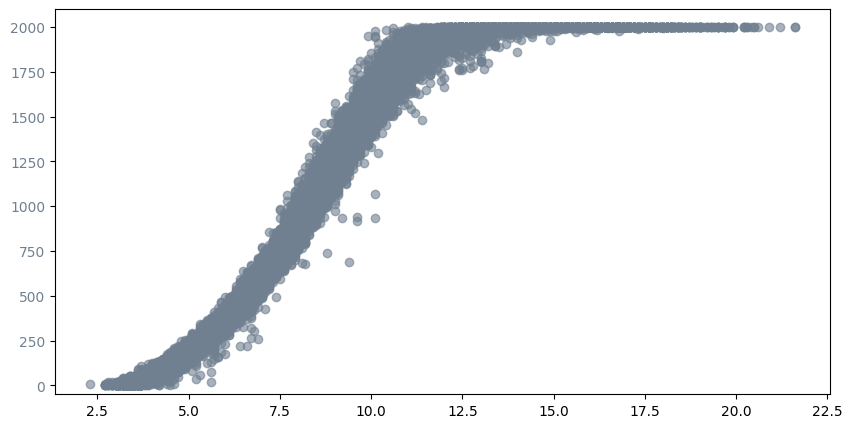

In [297]:
# Create a secondary y-axis with a slate gray color
plt.scatter(merged_df["Amb_WindSpeed_Avg"], merged_df["Grd_Prod_Pwr_Avg"], color='slategray', label='Wind Power (W)', alpha=0.6)  # Muted slate gray color
  # Secondary y-axis label color
plt.tick_params(axis='y', labelcolor='slategray')  # Secondary y-axis label tick color
plt.ylim(-50, 2100)


## Start mechanistic model

In [298]:
# Tip Speed Ratio (TSR)

conversion_factor = 2 * np.pi / 60
rotor_diameter = 90

merged_df["tsr"] = (merged_df["Rtr_RPM_Avg"]* conversion_factor) * (rotor_diameter/2) / merged_df["Amb_WindSpeed_Avg"]

merged_df = merged_df[merged_df["Amb_WindSpeed_Avg"] != 0]

In [299]:
# Tip Speed Ratio (TSR)

conversion_factor = 2 * np.pi / 60
rotor_diameter = 90

merged_df17["tsr"] = (merged_df17["Rtr_RPM_Avg"]* conversion_factor) * (rotor_diameter/2) / merged_df17["Amb_WindSpeed_Avg"]

merged_df17 = merged_df17[merged_df17["Amb_WindSpeed_Avg"] != 0]

In [300]:
# calculate wind power column
# Calculate actual cp

"""Amb_Temp_Avg, Avg_AmbientTemp"""
Arotor = 6362 #m^2 rotor area

# new column for power in the wind itself. 
merged_df["p_wind"] = 0.5*merged_df["airdensity"]*Arotor*(merged_df["Amb_WindSpeed_Avg"]**3)/1000 #kW

merged_df = merged_df[merged_df["p_wind"] != 0]
# cp = p_turbine / p_wind
merged_df["cp_actual"] =  merged_df["Grd_Prod_Pwr_Avg"] / merged_df["p_wind"]

merged_df = merged_df[merged_df["cp_actual"] != 0]

In [301]:
# calculate wind power column
# Calculate actual cp

# new column for power in the wind itself. 
merged_df17["p_wind"] = 0.5*merged_df17["airdensity"]*Arotor*(merged_df17["Amb_WindSpeed_Avg"]**3)/1000 #kW


In [302]:
merged_df17["cp_actual"] =  merged_df17["Grd_Prod_Pwr_Avg"] / merged_df17["p_wind"]

In [303]:
# calculate wind power column
# Calculate actual cp

# new column for power in the wind itself. 
merged_df17["p_wind"] = 0.5*merged_df17["airdensity"]*Arotor*(merged_df17["Amb_WindSpeed_Avg"]**3)/1000 #kW


Optimal max_depth=7, n_estimators=100 → Test RMSE=41.108


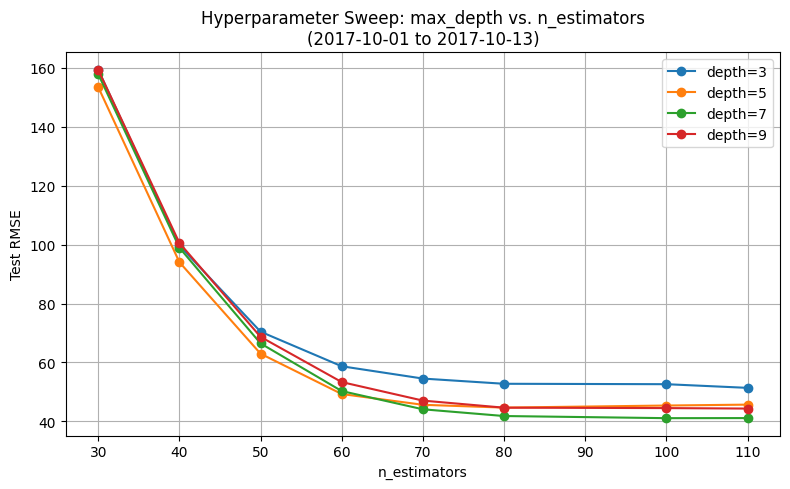

In [304]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# ——— 1) Specify features and target ———
feature_columns = [
    "Avg_Pressure",
    "Avg_Humidity",
    "Amb_Temp_Avg",
    "Gen_RPM_Avg",
    "Amb_WindSpeed_Avg"
]
target_column = 'Grd_Prod_Pwr_Avg'

# ——— 2) Prepare train (2016) set ———
X_train = merged_df[feature_columns]
y_train = merged_df[target_column]

# ——— 3) Filter 2017 test window ———
merged_df17['Timestamp'] = pd.to_datetime(merged_df17['Timestamp'])
mask = (
    (merged_df17["Timestamp"] >= "2017-10-01") &
    (merged_df17["Timestamp"] <= "2017-10-13")
)
test_df = merged_df17.loc[mask]

X_test = test_df[feature_columns]
y_test = test_df[target_column]

# ——— 4) Fixed learning rate from your LR‑finder ———
best_lr = 0.05

# ——— 5) Grid for max_depth & n_estimators ———
max_depths        = [3, 5, 7, 9]
n_estimators_list = [30, 40, 50, 60, 70, 80, 100, 110]

# ——— 6) Time‑based hyperparameter sweep ———
results = []
for md in max_depths:
    for ne in n_estimators_list:
        model = XGBRegressor(
            learning_rate=best_lr,
            max_depth=md,
            n_estimators=ne,
            objective='reg:squarederror',
            verbosity=0,
            n_jobs=-1,
            random_state=42
        )
        # train on 2016
        model.fit(X_train, y_train)
        # evaluate on 2017‑10‑01 to 2017‑10‑13
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results.append({
            'max_depth':    md,
            'n_estimators': ne,
            'rmse':         rmse
        })

df_results = pd.DataFrame(results)

# ——— 7) Find best combo ———
opt = df_results.loc[df_results['rmse'].idxmin()]
print(f"Optimal max_depth={int(opt.max_depth)}, "
      f"n_estimators={int(opt.n_estimators)} → "
      f"Test RMSE={opt.rmse:.3f}")

# ——— 8) Plot RMSE vs. n_estimators for each depth ———
plt.figure(figsize=(8, 5))
for md in max_depths:
    subset = df_results[df_results['max_depth'] == md]
    plt.plot(subset['n_estimators'], subset['rmse'], marker='o', label=f"depth={md}")

# Highlight the optimal point
"""plt.scatter([opt.n_estimators], [opt.rmse], s=120, marker='X', label='Optimal')"""
"""plt.text(opt.n_estimators, opt.rmse,
         f"  ({int(opt.max_depth)}, {int(opt.n_estimators)})",
         va='bottom')"""

plt.xlabel('n_estimators')
plt.ylabel('Test RMSE')
plt.title('Hyperparameter Sweep: max_depth vs. n_estimators\n(2017‑10‑01 to 2017‑10‑13)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [305]:
"""print(y_train.isna().sum())  # Count NaNs
print(np.isinf(y_train).sum())  # Count infinities"""

'print(y_train.isna().sum())  # Count NaNs\nprint(np.isinf(y_train).sum())  # Count infinities'

## Xgboost model:

learning_rates=0.05, max_depth=7, n_estimators=230,random_state=42,n_jobs=-1

result:
Model Performance Metrics (2017-10-01 to 2017-10-13):
Mean Squared Error (MSE): 2260.05
Root Mean Squared Error (RMSE): 47.54
Mean Absolute Error (MAE): 31.85
MAPE Score: 0.4886
R² Score: 0.9958

In [306]:
# Step 2: Specify the feature columns and the target variable
feature_columns = ["Avg_Pressure", "Avg_Humidity", "Amb_Temp_Avg", "Gen_RPM_Avg", "Amb_WindSpeed_Avg"]  # Features
target_column = 'Grd_Prod_Pwr_Avg'  # Target variable

# Step 3: Prepare the training data from merged_df
X_train = merged_df[feature_columns]  # Feature set for training
y_train = merged_df[target_column]   # Target variable for training

# Step 4: Prepare the prediction data from merged_df17
X_test = merged_df17[feature_columns]  # Feature set for predictions
X_eval = merged_df17[target_column]
# Step 5: Initialize the XGBoost model with optimal hyperparameters
model = XGBRegressor(learning_rates=0.05, max_depth=7, n_estimators=100,random_state=42,n_jobs=-1)

# Step 6: Train the model
model.fit(X_train, y_train)

# Step 7: Make predictions on the merged_df17 dataset
predictions = model.predict(X_test)

# Step 8: Evaluate the model on merged_df (Optional)
train_predictions = model.predict(X_train)

# Check if the target variable is binary (classification)
if isinstance(y_train, pd.Series) and y_train.nunique() <= 2:
    accuracy = accuracy_score(y_train, train_predictions.round())
    print(f'Accuracy on Training Data: {accuracy:.2f}')
else:
    # Regression Metrics
    mse = mean_squared_error(y_train, train_predictions)
    mae = mean_absolute_error(y_train, train_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_train, train_predictions)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100
    
    print(f'Mean Squared Error (MSE): {mse:.2f}')
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'R² Score: {r2:.2f}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Step 9: Store predictions in merged_df17
merged_df17["xgboost_pred_2017"] = predictions


Mean Squared Error (MSE): 518.22
Mean Absolute Error (MAE): 16.05
Root Mean Squared Error (RMSE): 22.76
R² Score: 1.00
Mean Absolute Percentage Error (MAPE): 13.53%


Her we find the optimal depth and width

put in the learning rate from learning rate finder

In [307]:



model.get_params()


{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 7,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'learning_rates': 0.05}

In [308]:
"""from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Step 1: Prepare your data
feature_columns = ["Avg_Pressure", "Avg_Humidity", "Amb_Temp_Avg", "Gen_RPM_Avg", "Amb_WindSpeed_Avg"]
target_column = 'Grd_Prod_Pwr_Avg'

X_train = merged_df[feature_columns]
y_train = merged_df[target_column]

# Step 2: Define the hyperparameter ranges
learning_rates = [0.01, 0.05, 0.10]
max_depths = list(range(3, 10))
n_estimators_list = [200, 400, 600, 800, 1000]

# Containers for metrics
lr_rmse, lr_mae, lr_r2 = [], [], []
md_rmse, md_mae, md_r2 = [], [], []
ne_rmse, ne_mae, ne_r2 = [], [], []

# Step 3: Evaluate across learning_rate
for lr in learning_rates:
    model = XGBRegressor(learning_rate=lr)
    model.fit(X_train, y_train)
    preds = model.predict(X_train)
    lr_rmse.append(np.sqrt(mean_squared_error(y_train, preds)))
    lr_mae.append(mean_absolute_error(y_train, preds))
    lr_r2.append(r2_score(y_train, preds))

# Plot A: learning_rate
plt.figure()
plt.plot(learning_rates, lr_rmse, marker='o', label='RMSE')
plt.plot(learning_rates, lr_mae, marker='o', label='MAE')
plt.plot(learning_rates, lr_r2, marker='o', label='R²')
plt.xlabel('learning_rate')
plt.ylabel('Error / R²')
plt.title('A: Impact of learning_rate')
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Evaluate across max_depth
for md in max_depths:
    model = XGBRegressor(max_depth=md)
    model.fit(X_train, y_train)
    preds = model.predict(X_train)
    md_rmse.append(np.sqrt(mean_squared_error(y_train, preds)))
    md_mae.append(mean_absolute_error(y_train, preds))
    md_r2.append(r2_score(y_train, preds))

# Plot B: max_depth
plt.figure()
plt.plot(max_depths, md_rmse, marker='o', label='RMSE')
plt.plot(max_depths, md_mae, marker='o', label='MAE')
plt.plot(max_depths, md_r2, marker='o', label='R²')
plt.xlabel('max_depth')
plt.ylabel('Error / R²')
plt.title('B: Impact of max_depth')
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Evaluate across n_estimators
for ne in n_estimators_list:
    model = XGBRegressor(n_estimators=ne)
    model.fit(X_train, y_train)
    preds = model.predict(X_train)
    ne_rmse.append(np.sqrt(mean_squared_error(y_train, preds)))
    ne_mae.append(mean_absolute_error(y_train, preds))
    ne_r2.append(r2_score(y_train, preds))

# Plot C: n_estimators
plt.figure()
plt.plot(n_estimators_list, ne_rmse, marker='o', label='RMSE')
plt.plot(n_estimators_list, ne_mae, marker='o', label='MAE')
plt.plot(n_estimators_list, ne_r2, marker='o', label='R²')
plt.xlabel('n_estimators')
plt.ylabel('Error / R²')
plt.title('C: Impact of n_estimators')
plt.legend()
plt.grid(True)
plt.show()
"""

'from xgboost import XGBRegressor\nimport matplotlib.pyplot as plt\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score\nimport numpy as np\n\n# Step 1: Prepare your data\nfeature_columns = ["Avg_Pressure", "Avg_Humidity", "Amb_Temp_Avg", "Gen_RPM_Avg", "Amb_WindSpeed_Avg"]\ntarget_column = \'Grd_Prod_Pwr_Avg\'\n\nX_train = merged_df[feature_columns]\ny_train = merged_df[target_column]\n\n# Step 2: Define the hyperparameter ranges\nlearning_rates = [0.01, 0.05, 0.10]\nmax_depths = list(range(3, 10))\nn_estimators_list = [200, 400, 600, 800, 1000]\n\n# Containers for metrics\nlr_rmse, lr_mae, lr_r2 = [], [], []\nmd_rmse, md_mae, md_r2 = [], [], []\nne_rmse, ne_mae, ne_r2 = [], [], []\n\n# Step 3: Evaluate across learning_rate\nfor lr in learning_rates:\n    model = XGBRegressor(learning_rate=lr)\n    model.fit(X_train, y_train)\n    preds = model.predict(X_train)\n    lr_rmse.append(np.sqrt(mean_squared_error(y_train, preds)))\n    lr_mae.append(mean_absolute_e

Find optimal learning rate: (you have to go back an train again after finding it)

In [309]:
"""import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

# ——— 1) Prepare data ———
feature_columns = ["Avg_Pressure", "Avg_Humidity",
                   "Amb_Temp_Avg", "Gen_RPM_Avg", "Amb_WindSpeed_Avg"]
target_column   = 'Grd_Prod_Pwr_Avg'

X_train = merged_df[feature_columns]
y_train = merged_df[target_column]

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)

# ——— 2) Build a log‑spaced LR schedule ———
num_rounds = 100
min_lr     = 1e-7
max_lr     = 1.0
lrs = np.logspace(np.log10(min_lr), np.log10(max_lr), num=num_rounds)

# ——— 3) Set up params and train with callbacks ———
params = {
    "objective": "reg:squarederror",
    "verbosity": 0,
}

evals_result = {}
bst = xgb.train(
    params        = params,
    dtrain        = dtrain,
    num_boost_round = num_rounds,
    evals         = [(dtrain, "train")],
    evals_result  = evals_result,
    callbacks     = [
        # this will call lr[i] at round i
        xgb.callback.LearningRateScheduler(lambda i: float(lrs[i]))
    ]
)

# pull out the per‐round training RMSE history
hist = evals_result["train"]["rmse"]

# ——— 4) Plot loss vs. LR ———
plt.figure(figsize=(6,4))
plt.plot(lrs, hist, lw=2)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Training RMSE')
plt.title('XGBoost Learning‑Rate Finder')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()
"""

'import numpy as np\nimport matplotlib.pyplot as plt\nimport xgboost as xgb\n\n# ——— 1) Prepare data ———\nfeature_columns = ["Avg_Pressure", "Avg_Humidity",\n                   "Amb_Temp_Avg", "Gen_RPM_Avg", "Amb_WindSpeed_Avg"]\ntarget_column   = \'Grd_Prod_Pwr_Avg\'\n\nX_train = merged_df[feature_columns]\ny_train = merged_df[target_column]\n\n# Convert to DMatrix\ndtrain = xgb.DMatrix(X_train, label=y_train)\n\n# ——— 2) Build a log‑spaced LR schedule ———\nnum_rounds = 100\nmin_lr     = 1e-7\nmax_lr     = 1.0\nlrs = np.logspace(np.log10(min_lr), np.log10(max_lr), num=num_rounds)\n\n# ——— 3) Set up params and train with callbacks ———\nparams = {\n    "objective": "reg:squarederror",\n    "verbosity": 0,\n}\n\nevals_result = {}\nbst = xgb.train(\n    params        = params,\n    dtrain        = dtrain,\n    num_boost_round = num_rounds,\n    evals         = [(dtrain, "train")],\n    evals_result  = evals_result,\n    callbacks     = [\n        # this will call lr[i] at round i\n       

This script fits the last part of network with new learning rate (not in use currently)

In [310]:
"""import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ——— 1) Prepare data ———
feature_columns = ["Avg_Pressure", "Avg_Humidity",
                   "Amb_Temp_Avg", "Gen_RPM_Avg", "Amb_WindSpeed_Avg"]
target_column   = 'Grd_Prod_Pwr_Avg'

X_train = merged_df[feature_columns]
y_train = merged_df[target_column]
X_test  = merged_df17[feature_columns]

# Convert to DMatrix for the finder
dtrain = xgb.DMatrix(X_train, label=y_train)

# ——— 2) Run the LR‑finder ———
num_rounds = 100
lrs = np.logspace(-7, 0, num=num_rounds)  # 1e-7 → 1

evals_result = {}
finder = xgb.train(
    {"objective":"reg:squarederror", "verbosity":0},
    dtrain,
    num_boost_round = num_rounds,
    evals           = [(dtrain, "train")],
    evals_result    = evals_result,
    callbacks       = [xgb.callback.LearningRateScheduler(lambda i: float(lrs[i]))]
)

hist = np.array(evals_result["train"]["rmse"])

# Plot the finder curve
plt.figure(figsize=(6,4))
plt.plot(lrs, hist, lw=2)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Training RMSE')
plt.title('XGBoost LR‑Finder')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

# ——— 3) Pick your best LR ———
best_idx = hist.argmin()
best_lr  = float(lrs[best_idx])
print(f"Minimum RMSE = {hist[best_idx]:.4f} at learning_rate ≈ {best_lr:.2e}")

# (Optionally choose a more conservative “safe” lr ↓10×:)
safe_lr = best_lr / 10
print(f"Safe learning_rate ≈ {safe_lr:.2e}")

# ——— 4) Final training with that LR ———
final_model = XGBRegressor(
    learning_rate = safe_lr,
    n_estimators   = 500,           # feel free to bump this up
    max_depth      = 5,             # your chosen depth
    objective      = "reg:squarederror",
    verbosity      = 1
)
final_model.fit(X_train, y_train)

# Step 5: Make predictions
preds = final_model.predict(X_test)

# Step 6: (Optional) Evaluate on training for sanity
train_preds = final_model.predict(X_train)
mse  = mean_squared_error(y_train, train_preds)
mae  = mean_absolute_error(y_train, train_preds)
rmse = np.sqrt(mse)
r2   = r2_score(y_train, train_preds)
print(f"Train → MSE: {mse:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")

# Step 7: Store predictions
merged_df17["xgboost_pred_2017"] = preds
"""

'import numpy as np\nimport matplotlib.pyplot as plt\nimport xgboost as xgb\nfrom xgboost import XGBRegressor\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score\n\n# ——— 1) Prepare data ———\nfeature_columns = ["Avg_Pressure", "Avg_Humidity",\n                   "Amb_Temp_Avg", "Gen_RPM_Avg", "Amb_WindSpeed_Avg"]\ntarget_column   = \'Grd_Prod_Pwr_Avg\'\n\nX_train = merged_df[feature_columns]\ny_train = merged_df[target_column]\nX_test  = merged_df17[feature_columns]\n\n# Convert to DMatrix for the finder\ndtrain = xgb.DMatrix(X_train, label=y_train)\n\n# ——— 2) Run the LR‑finder ———\nnum_rounds = 100\nlrs = np.logspace(-7, 0, num=num_rounds)  # 1e-7 → 1\n\nevals_result = {}\nfinder = xgb.train(\n    {"objective":"reg:squarederror", "verbosity":0},\n    dtrain,\n    num_boost_round = num_rounds,\n    evals           = [(dtrain, "train")],\n    evals_result    = evals_result,\n    callbacks       = [xgb.callback.LearningRateScheduler(lambda i: float(lrs[i]))]\n

In [311]:
booster = model.get_booster()
print(booster.attributes())
print(booster.save_config())


{}
{"learner":{"generic_param":{"device":"cpu","fail_on_invalid_gpu_id":"0","n_jobs":"-1","nthread":"-1","random_state":"42","seed":"42","seed_per_iteration":"0","validate_parameters":"1"},"gradient_booster":{"gbtree_model_param":{"num_parallel_tree":"1","num_trees":"100"},"gbtree_train_param":{"process_type":"default","tree_method":"auto","updater":"grow_quantile_histmaker","updater_seq":"grow_quantile_histmaker"},"name":"gbtree","specified_updater":false,"tree_train_param":{"alpha":"0","cache_opt":"1","colsample_bylevel":"1","colsample_bynode":"1","colsample_bytree":"1","eta":"0.300000012","gamma":"0","grow_policy":"depthwise","interaction_constraints":"","lambda":"1","learning_rate":"0.300000012","max_bin":"256","max_cat_threshold":"64","max_cat_to_onehot":"4","max_delta_step":"0","max_depth":"7","max_leaves":"0","min_child_weight":"1","min_split_loss":"0","monotone_constraints":"()","refresh_leaf":"1","reg_alpha":"0","reg_lambda":"1","sampling_method":"uniform","sketch_ratio":"2","

In [312]:
"""from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Get number of boosting rounds (trees)
num_trees = len(model.get_booster().get_dump())  # Counts actual trees in the model

rmse_values = []

# Evaluate predictions using increasing numbers of trees
for i in range(1, num_trees + 1):
    y_pred_partial = model.predict(X_train, iteration_range=(0, i))
    rmse = np.sqrt(mean_squared_error(y_train, y_pred_partial))
    rmse_values.append(rmse)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_trees + 1), rmse_values, label="Training RMSE")
plt.xlabel("Number of Trees (Boosting Rounds)")
plt.ylabel("RMSE")
plt.title("Simulated Learning Curve (Training RMSE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
"""

'from sklearn.metrics import mean_squared_error\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Get number of boosting rounds (trees)\nnum_trees = len(model.get_booster().get_dump())  # Counts actual trees in the model\n\nrmse_values = []\n\n# Evaluate predictions using increasing numbers of trees\nfor i in range(1, num_trees + 1):\n    y_pred_partial = model.predict(X_train, iteration_range=(0, i))\n    rmse = np.sqrt(mean_squared_error(y_train, y_pred_partial))\n    rmse_values.append(rmse)\n\n# Plotting the learning curve\nplt.figure(figsize=(10, 6))\nplt.plot(range(1, num_trees + 1), rmse_values, label="Training RMSE")\nplt.xlabel("Number of Trees (Boosting Rounds)")\nplt.ylabel("RMSE")\nplt.title("Simulated Learning Curve (Training RMSE)")\nplt.grid(True)\nplt.legend()\nplt.tight_layout()\nplt.show()\n'

# Error evaluation

In [313]:
# mean error of hybrid model
y_difference_xgboost = merged_df17["xgboost_pred_2017"] - merged_df17["Grd_Prod_Pwr_Avg"]

# "modelling_error" is going to be used to visualize the errors in all plots going forward
modelling_error_xgboost = np.abs(np.std(y_difference_xgboost))

In [314]:
modelling_error_xgboost


np.float64(176.44745807439782)

(-50.0, 2100.0)

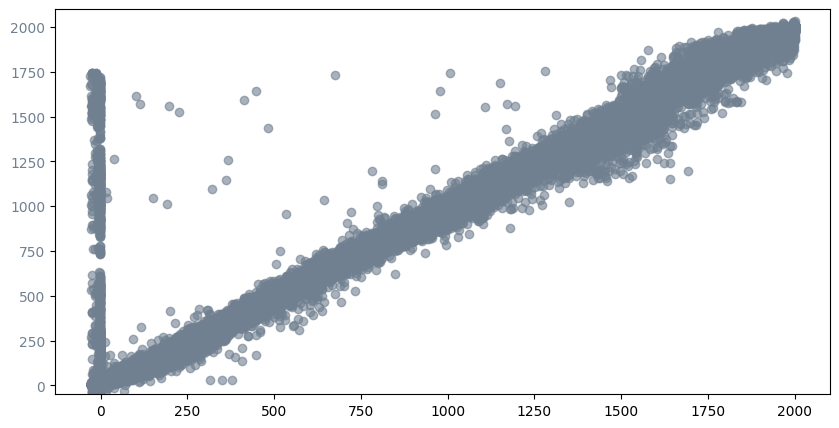

In [315]:
# Create a secondary y-axis with a slate gray color
plt.scatter(merged_df17["Grd_Prod_Pwr_Avg"], merged_df17["xgboost_pred_2017"], color='slategray', label='Wind Power (W)', alpha=0.6)  # Muted slate gray color
  # Secondary y-axis label color
plt.tick_params(axis='y', labelcolor='slategray')  # Secondary y-axis label tick color
plt.ylim(-50, 2100)

(-50.0, 2100.0)

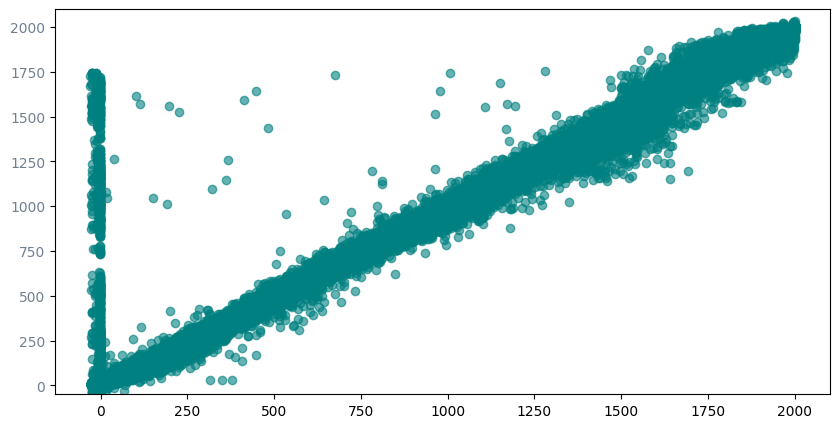

In [316]:
# Create a secondary y-axis with a slate gray color
plt.scatter(merged_df17["Grd_Prod_Pwr_Avg"], merged_df17["xgboost_pred_2017"], color='teal', label='Wind Power (W)', alpha=0.6)  # Muted slate gray color
  # Secondary y-axis label color
plt.tick_params(axis='y', labelcolor='slategray')  # Secondary y-axis label tick color
plt.ylim(-50, 2100)


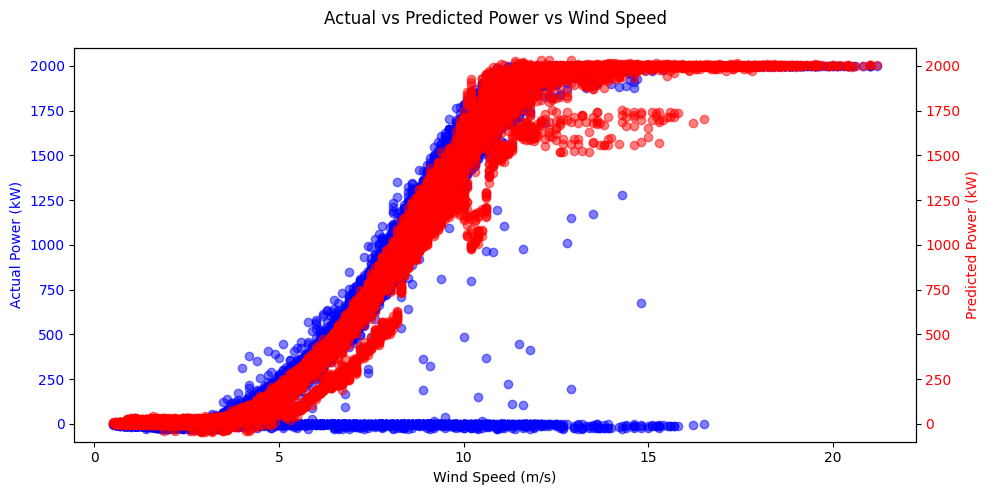

In [317]:
import matplotlib.pyplot as plt

# Define x (Windspeed), y1 (Actual), and y2 (Predicted)
x = merged_df17["Amb_WindSpeed_Avg"]  # Wind speed (X-axis)
y_actual = merged_df17["Grd_Prod_Pwr_Avg"]  # Actual power production (Left Y-axis)
y_predicted = merged_df17["xgboost_pred_2017"]  # Predicted power production (Right Y-axis)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot actual values on left y-axis
ax1.set_xlabel("Wind Speed (m/s)")
ax1.set_ylabel("Actual Power (kW)", color="blue")
ax1.scatter(x, y_actual, color="blue", label="Actual Power", alpha=0.5)
ax1.tick_params(axis="y", labelcolor="blue")
plt.ylim(-100,2100)
# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Predicted Power (kW)", color="red")
ax2.scatter(x, y_predicted, color="red", label="Predicted Power", alpha=0.5)
ax2.tick_params(axis="y", labelcolor="red")


# Add title and show legend
fig.suptitle("Actual vs Predicted Power vs Wind Speed")
fig.tight_layout()
plt.ylim(-100,2100)
plt.show()


In [318]:
print(merged_df17.columns)


Index(['Turbine_ID', 'Timestamp', 'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg',
       'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg',
       'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg',
       ...
       'DistanceAirPress', 'AirRessureSensorZeroOffset',
       'Anemometer1_Avg_Freq', 'Anemometer2_Avg_Freq', 'Pressure_Avg_Freq',
       'airdensity', 'tsr', 'p_wind', 'cp_actual', 'xgboost_pred_2017'],
      dtype='object', length=128)


### What does this look for a smaller period

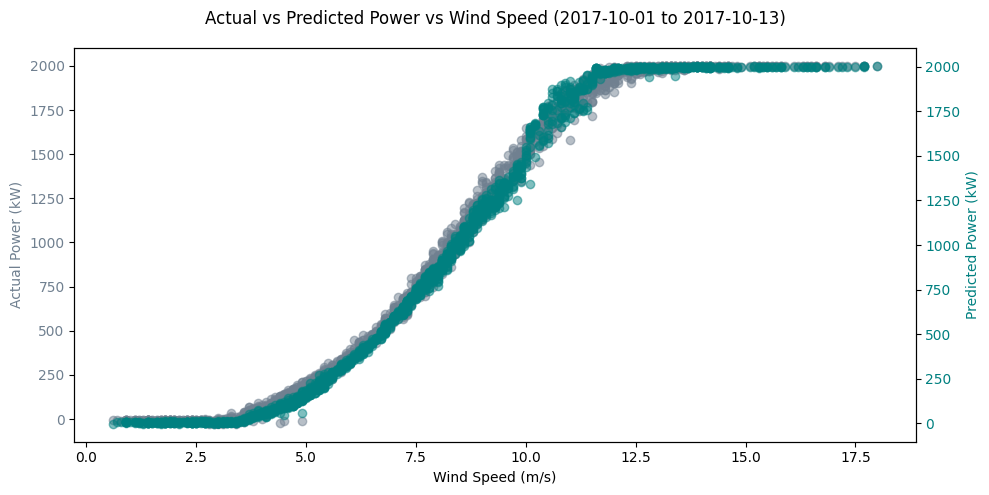

In [319]:
import matplotlib.pyplot as plt

# Ensure timestamp is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Filter data for the date range 2017-10-01 to 2017-10-13
filtered_df = merged_df17[(merged_df17["Timestamp"] >= "2017-10-01") & 
                          (merged_df17["Timestamp"] <= "2017-10-13")]

# Define x (Windspeed), y1 (Actual), and y2 (Predicted)
x = filtered_df["Amb_WindSpeed_Avg"]  # Wind speed (X-axis)
y_actual = filtered_df["Grd_Prod_Pwr_Avg"]  # Actual power production (Left Y-axis)
y_predicted = filtered_df["xgboost_pred_2017"]  # Predicted power production (Right Y-axis)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot actual values on left y-axis
ax1.set_xlabel("Wind Speed (m/s)")
ax1.set_ylabel("Actual Power (kW)", color="slategrey")
ax1.scatter(x, y_actual, color="slategrey", label="Actual Power", alpha=0.5)
ax1.tick_params(axis="y", labelcolor="slategrey")

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Predicted Power (kW)", color="teal")
ax2.scatter(x, y_predicted, color="teal", label="Predicted Power", alpha=0.5)
ax2.tick_params(axis="y", labelcolor="teal")

# Add title and show legend
fig.suptitle("Actual vs Predicted Power vs Wind Speed (2017-10-01 to 2017-10-13)")
fig.tight_layout()
plt.show()


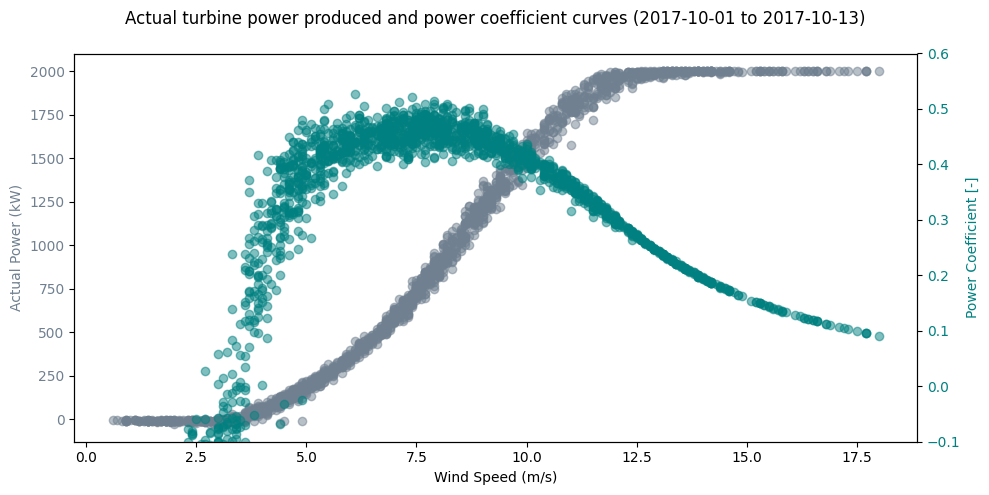

In [320]:
import matplotlib.pyplot as plt

# Ensure timestamp is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])


# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot actual values on left y-axis
ax1.set_xlabel("Wind Speed (m/s)")
ax1.set_ylabel("Actual Power (kW)", color="slategrey")
ax1.scatter(x, y_actual, color="slategrey", label="Actual Power", alpha=0.5)
ax1.tick_params(axis="y", labelcolor="slategrey")

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Power Coefficient [-]", color="teal")
ax2.scatter(x, filtered_df["cp_actual"], color="teal", label="C_p [-]", alpha=0.5)
ax2.tick_params(axis="y", labelcolor="teal")
ax2.set_ylim(-0.1,0.6)
# Add title and show legend
fig.suptitle("Actual turbine power produced and power coefficient curves (2017-10-01 to 2017-10-13)")
fig.tight_layout()
plt.show()


In [321]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Compute metrics
mse = mean_squared_error(y_actual, y_predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual, y_predicted)
r2 = r2_score(y_actual, y_predicted)
mape = mean_absolute_percentage_error(y_actual,y_predicted)
# Print metrics
print("Model Performance Metrics (2017-10-01 to 2017-10-13):")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"MAPE Score: {mape:.4f}")
print(f"R² Score: {r2:.4f}")

Model Performance Metrics (2017-10-01 to 2017-10-13):
Mean Squared Error (MSE): 2259.69
Root Mean Squared Error (RMSE): 47.54
Mean Absolute Error (MAE): 31.60
MAPE Score: 0.4903
R² Score: 0.9958


### Error calculation

In [322]:
# error models

# total error = model error + sensor error + actual error + operational error

# Percentage mode


# mean error
y_difference = y_predicted-y_actual

# "modelling_error" is going to be used to visualize the errors in all plots going forward
modelling_error = np.abs(np.std(y_difference))

In [323]:
modelling_error

np.float64(47.40554252399049)

In [324]:
# mean error of hybrid model
y_difference_inference = filtered_df["xgboost_pred_2017"] - filtered_df["Grd_Prod_Pwr_Avg"]

# "modelling_error" is going to be used to visualize the errors in all plots going forward
modelling_error_inference = np.abs(np.std(y_difference_inference))

In [325]:
modelling_error_inference

np.float64(47.40554252399049)

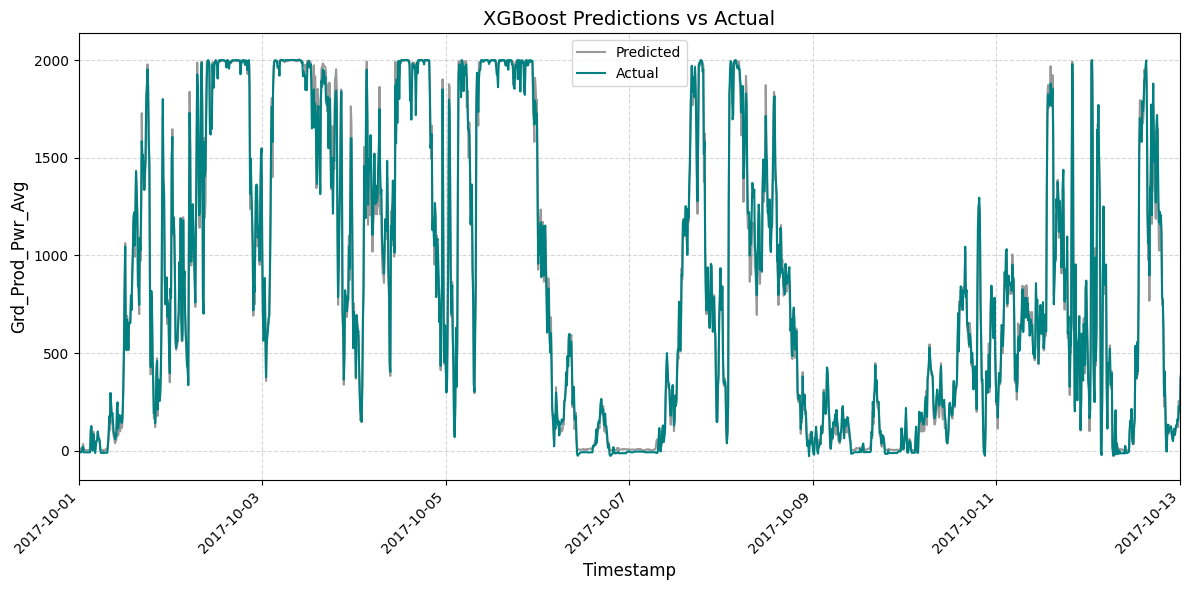

In [326]:
# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
filtered_df = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Line plot for predicted values
plt.plot(
    filtered_df["Timestamp"],  # Sorted timestamps
    filtered_df["xgboost_pred_2017"],  # Predictions
    color='grey', alpha=0.8, label='Predicted', linestyle='-', linewidth=1.5
)
plt.plot(
    filtered_df["Timestamp"],  # Sorted timestamps
    filtered_df[target_column],  # Actual target values
    color='teal', alpha=1, label='Actual', linestyle='-', linewidth=1.5
)
# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-13'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [327]:
modelling_error_inference

np.float64(47.40554252399049)

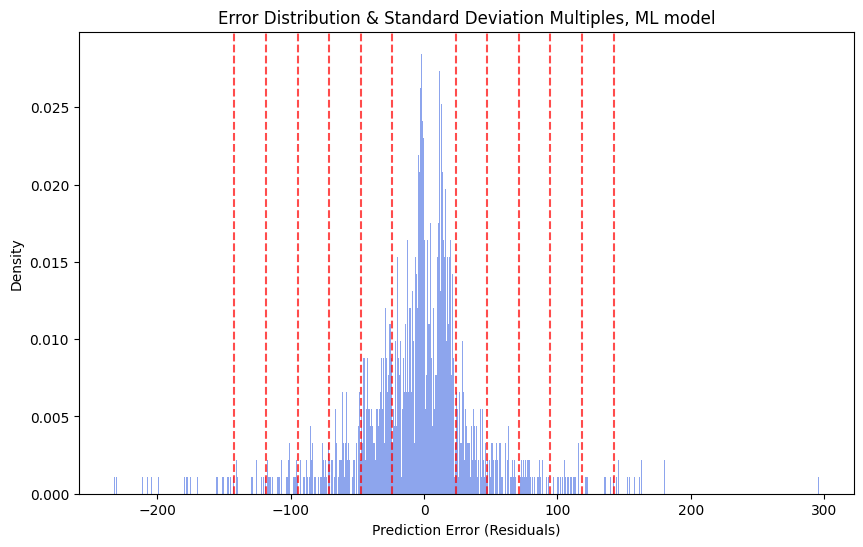

In [328]:

# Compute standard deviation of errors
std_dev = np.std(y_difference_inference)

# Define thresholds (multiples of sigma)
multiples_of_sigma = np.arange(0.5, 3.5, 0.5)  # From 0.5σ to 3σ
coverage_percentages = [(np.abs(y_difference_inference) <= m * std_dev).mean() * 100 for m in multiples_of_sigma]

plt.figure(figsize=(10, 6))
plt.hist(y_difference_inference, bins=1000, alpha=0.6, color='royalblue', density=True)

# Add vertical lines for standard deviation multiples
for m in multiples_of_sigma:
    plt.axvline(m * std_dev, color='red', linestyle='dashed', alpha=0.7)
    plt.axvline(-m * std_dev, color='red', linestyle='dashed', alpha=0.7)

plt.title("Error Distribution & Standard Deviation Multiples, ML model")
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Density")
plt.show()


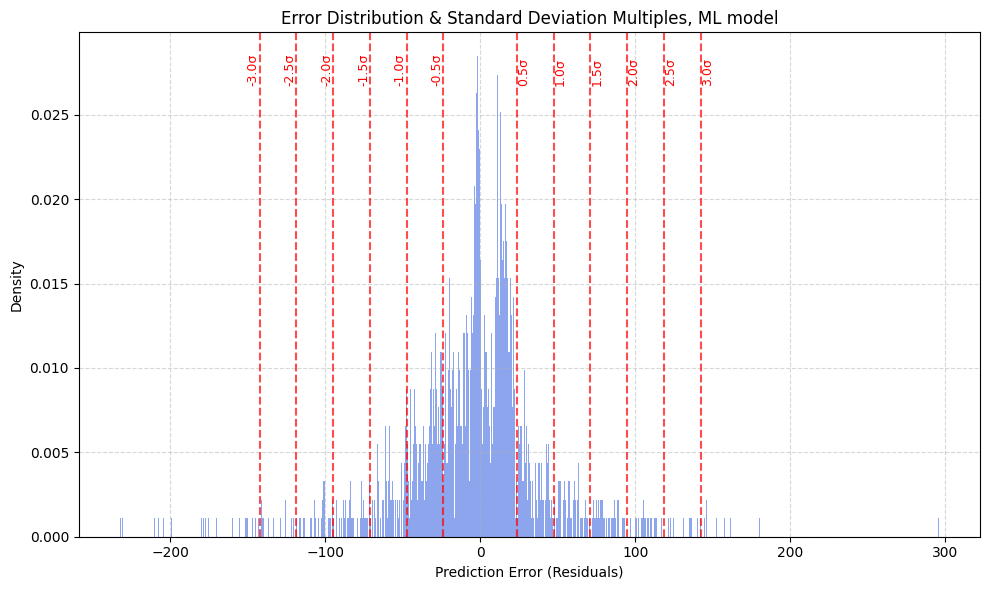

In [329]:
import matplotlib.pyplot as plt
import numpy as np

# Compute standard deviation of errors
std_dev = np.std(y_difference_inference)

# Define thresholds (multiples of sigma)
multiples_of_sigma = np.arange(0.5, 3.5, 0.5)  # From 0.5σ to 3σ
coverage_percentages = [(np.abs(y_difference_inference) <= m * std_dev).mean() * 100 for m in multiples_of_sigma]

plt.figure(figsize=(10, 6))
plt.hist(y_difference_inference, bins=1000, alpha=0.6, color='royalblue', density=True)

# Add vertical lines and text annotations for standard deviation multiples
for m in multiples_of_sigma:
    pos = m * std_dev
    neg = -m * std_dev
    plt.axvline(pos, color='red', linestyle='dashed', alpha=0.7)
    plt.axvline(neg, color='red', linestyle='dashed', alpha=0.7)
    plt.text(pos, plt.ylim()[1]*0.9, f'{m:.1f}σ', color='red', ha='left', fontsize=9, rotation=90)
    plt.text(neg, plt.ylim()[1]*0.9, f'-{m:.1f}σ', color='red', ha='right', fontsize=9, rotation=90)

plt.title("Error Distribution & Standard Deviation Multiples, ML model")
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Density")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


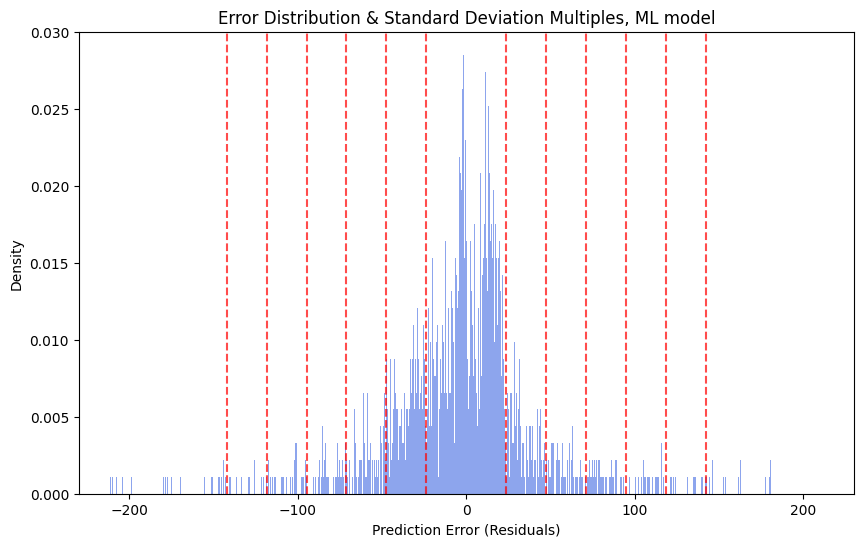

In [330]:

# Compute standard deviation of errors
std_dev = np.std(y_difference_inference)

# Define thresholds (multiples of sigma)
multiples_of_sigma = np.arange(0.5, 3.5, 0.5)  # From 0.5σ to 3σ
coverage_percentages = [(np.abs(y_difference_inference) <= m * std_dev).mean() * 100 for m in multiples_of_sigma]

plt.figure(figsize=(10, 6))
plt.hist(y_difference_inference, bins=1000, alpha=0.6, color='royalblue', density=True)

# Add vertical lines for standard deviation multiples
for m in multiples_of_sigma:
    plt.axvline(m * std_dev, color='red', linestyle='dashed', alpha=0.7)
    plt.axvline(-m * std_dev, color='red', linestyle='dashed', alpha=0.7)

plt.title("Error Distribution & Standard Deviation Multiples, ML model")
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Density")
plt.xlim(-230,230)
plt.ylim(0,0.03)
plt.show()


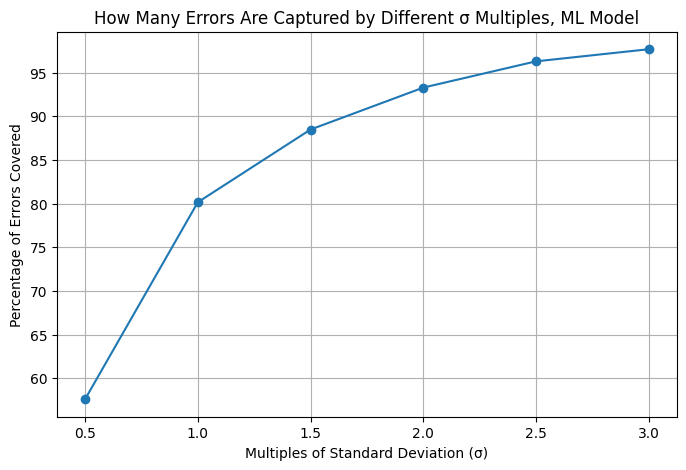

In [331]:
plt.figure(figsize=(8, 5))
plt.plot(multiples_of_sigma, coverage_percentages, marker='o', linestyle='-')

plt.xlabel("Multiples of Standard Deviation (σ)")
plt.ylabel("Percentage of Errors Covered")
plt.title("How Many Errors Are Captured by Different σ Multiples, ML Model")
plt.grid(True)

plt.show()

In [332]:
coverage_percentages


[np.float64(57.60555234239445),
 np.float64(80.16194331983806),
 np.float64(88.49045691150954),
 np.float64(93.29091960670908),
 np.float64(96.29843840370155),
 np.float64(97.68652400231348)]

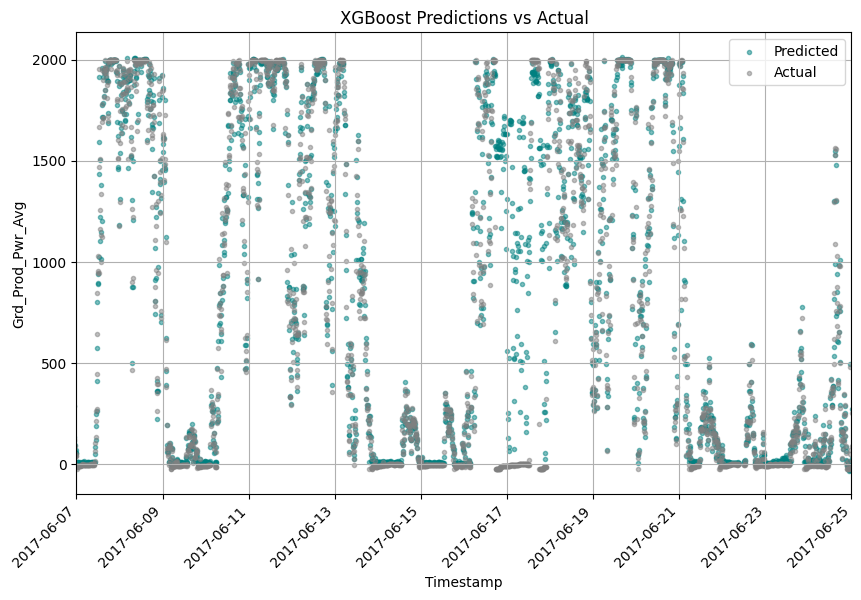

In [333]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(10, 6))

# Scatter plot for predicted values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions stored in 'cp_xgboost'
    c='teal', alpha=0.5, label='Predicted', marker="."
)

# Scatter plot for actual values (y_test)
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    c='grey', alpha=0.5, label='Actual', marker=".", 
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for data (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

plt.title("XGBoost Predictions vs Actual")
plt.xlabel("Timestamp")
plt.ylabel(target_column)
plt.legend()  # Show legend to distinguish between predicted and actual values
plt.grid(True)
plt.show()


## Set maximum power here:

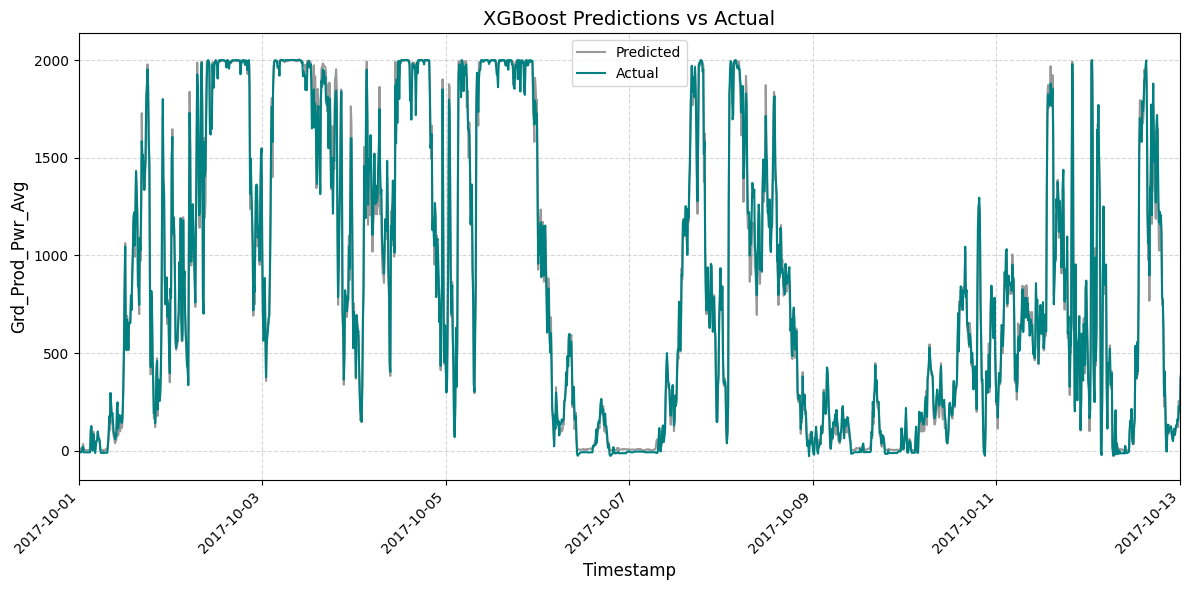

In [334]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Line plot for predicted values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    color='grey', alpha=0.8, label='Predicted', linestyle='-', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='teal', alpha=1, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-13'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [335]:
"""import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Line plot for hybrid model predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["p_hybrid"],  # Hybrid model predictions
    color='grey', alpha=0.8, label='Hybrid Model', linestyle='-', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='teal', alpha=1, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-13'))
# Title and labels
plt.title("Hybrid Model Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()"""


'import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Ensure Timestamp column is in datetime format\nmerged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])\n\n# Sort merged_df17 by "Timestamp" for better visualization\nmerged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")\n\nplt.figure(figsize=(12, 6))\n\n# Line plot for hybrid model predictions\nplt.plot(\n    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps\n    merged_df_filtered17_sorted["p_hybrid"],  # Hybrid model predictions\n    color=\'grey\', alpha=0.8, label=\'Hybrid Model\', linestyle=\'-\', linewidth=1.5\n)\n\n# Line plot for actual values\nplt.plot(\n    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps\n    merged_df_filtered17_sorted[target_column],  # Actual target values\n    color=\'teal\', alpha=1, label=\'Actual\', linestyle=\'-\', linewidth=1.5\n)\n\n# Highlight x-axis labels for better readability\nplt.xticks(rotation=45, ha=\'right\')\n\n# Define inter

Replication of maneesh work to see if data is faulty after maintenance in

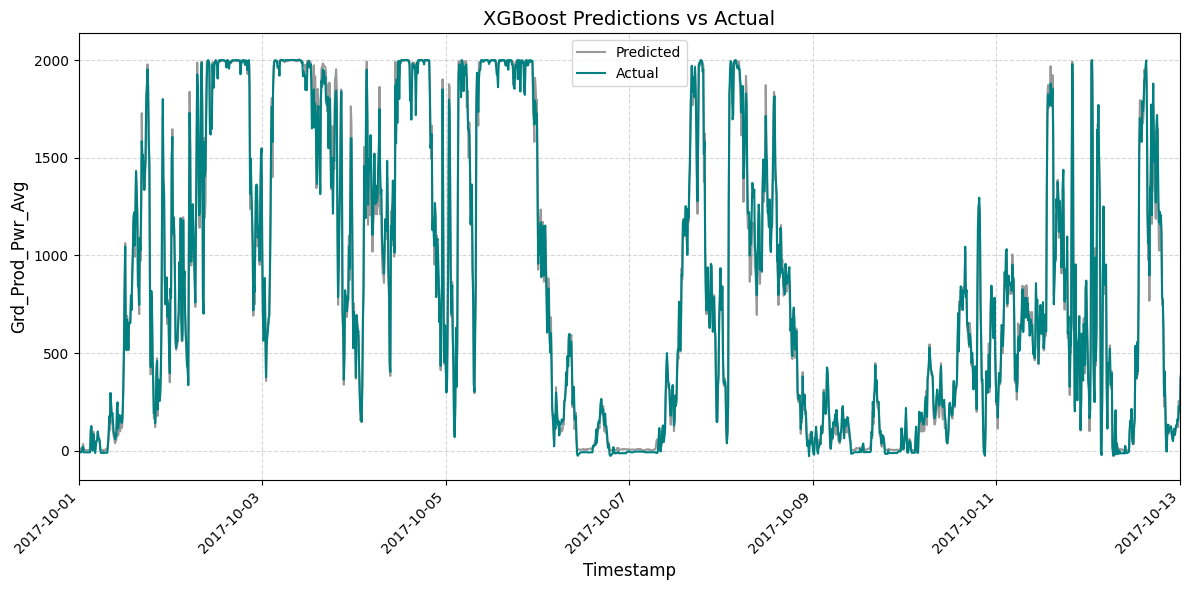

In [336]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Line plot for predicted values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    color='grey', alpha=0.8, label='Predicted', linestyle='-', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='teal', alpha=1, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-13'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


(np.float64(17324.0), np.float64(17525.0))

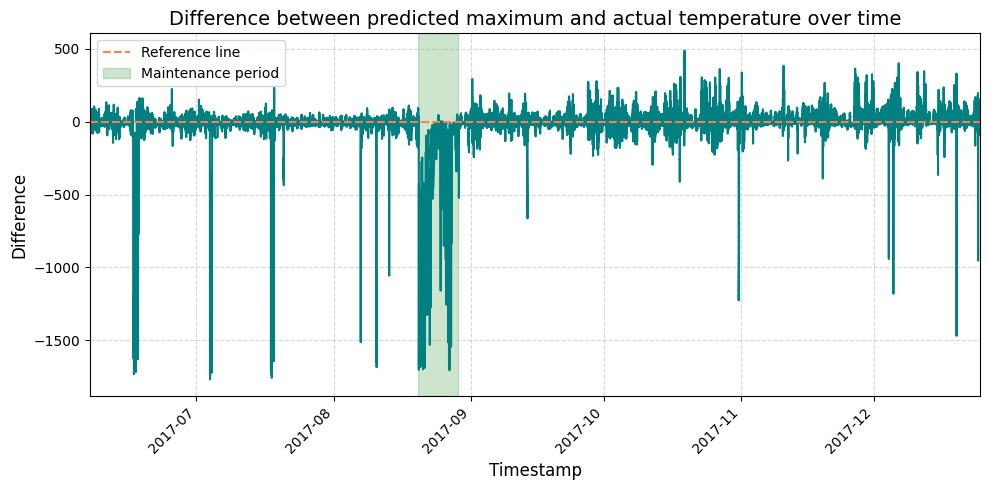

In [337]:
merged_df_filtered17_sorted["xgb_actual_diff"] =  merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["xgboost_pred_2017"]

plt.plot(merged_df_filtered17_sorted["Timestamp"],merged_df_filtered17_sorted["xgb_actual_diff"], color="teal")

# Add reference line for anomaly threshold
plt.axhline(y=0, color='coral', linestyle="--", label="Reference line")
# Add green shaded region between specified dates
plt.axvspan(pd.to_datetime('2017-08-20'), pd.to_datetime('2017-08-29'), color='green', alpha=0.2, label="Maintenance period")
# Configure plot
plt.title("Difference between predicted maximum and actual temperature over time", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Difference", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-12-25'))

<Axes: >

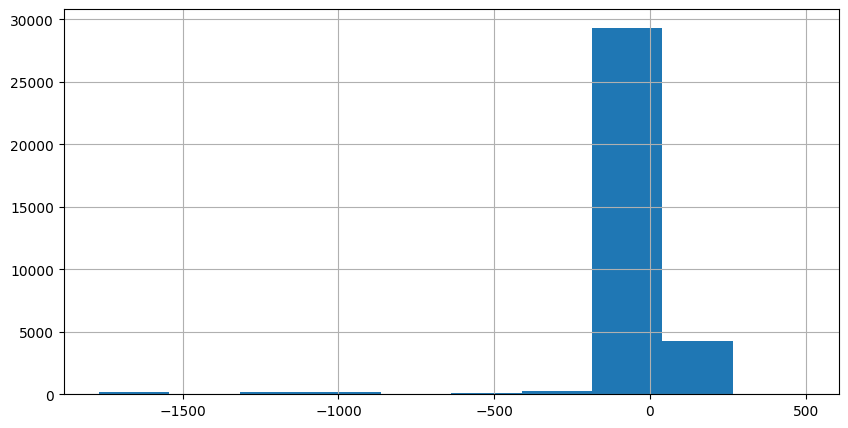

In [338]:
merged_df_filtered17_sorted["xgb_actual_diff"].hist()

In [339]:
"""import matplotlib.pyplot as plt
import pandas as pd

# Compute the difference between actual and predicted values for the hybrid model
merged_df_filtered17_sorted["hybrid_actual_diff"] = merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["p_hybrid"]

# Plot the difference over time
plt.plot(merged_df_filtered17_sorted["Timestamp"], merged_df_filtered17_sorted["hybrid_actual_diff"], color="teal")

# Add reference line for anomaly threshold
plt.axhline(y=0, color='coral', linestyle="--", label="Reference line")

# Add green shaded region between specified dates
plt.axvspan(pd.to_datetime('2017-08-20'), pd.to_datetime('2017-08-29'), color='green', alpha=0.2, label="Maintenance period")

# Configure plot
plt.title("Difference between Predicted and Actual Temperature Over Time (Hybrid Model)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Difference", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Set x-axis limits
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-12-25'))

plt.show()"""


'import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Compute the difference between actual and predicted values for the hybrid model\nmerged_df_filtered17_sorted["hybrid_actual_diff"] = merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["p_hybrid"]\n\n# Plot the difference over time\nplt.plot(merged_df_filtered17_sorted["Timestamp"], merged_df_filtered17_sorted["hybrid_actual_diff"], color="teal")\n\n# Add reference line for anomaly threshold\nplt.axhline(y=0, color=\'coral\', linestyle="--", label="Reference line")\n\n# Add green shaded region between specified dates\nplt.axvspan(pd.to_datetime(\'2017-08-20\'), pd.to_datetime(\'2017-08-29\'), color=\'green\', alpha=0.2, label="Maintenance period")\n\n# Configure plot\nplt.title("Difference between Predicted and Actual Temperature Over Time (Hybrid Model)", fontsize=14)\nplt.xlabel("Timestamp", fontsize=12)\nplt.ylabel("Difference", fontsize=12)\nplt.legend(fontsize=10)\nplt.grid(True, linestyle=\'--\', alph

Test of wide interval without uncertainty

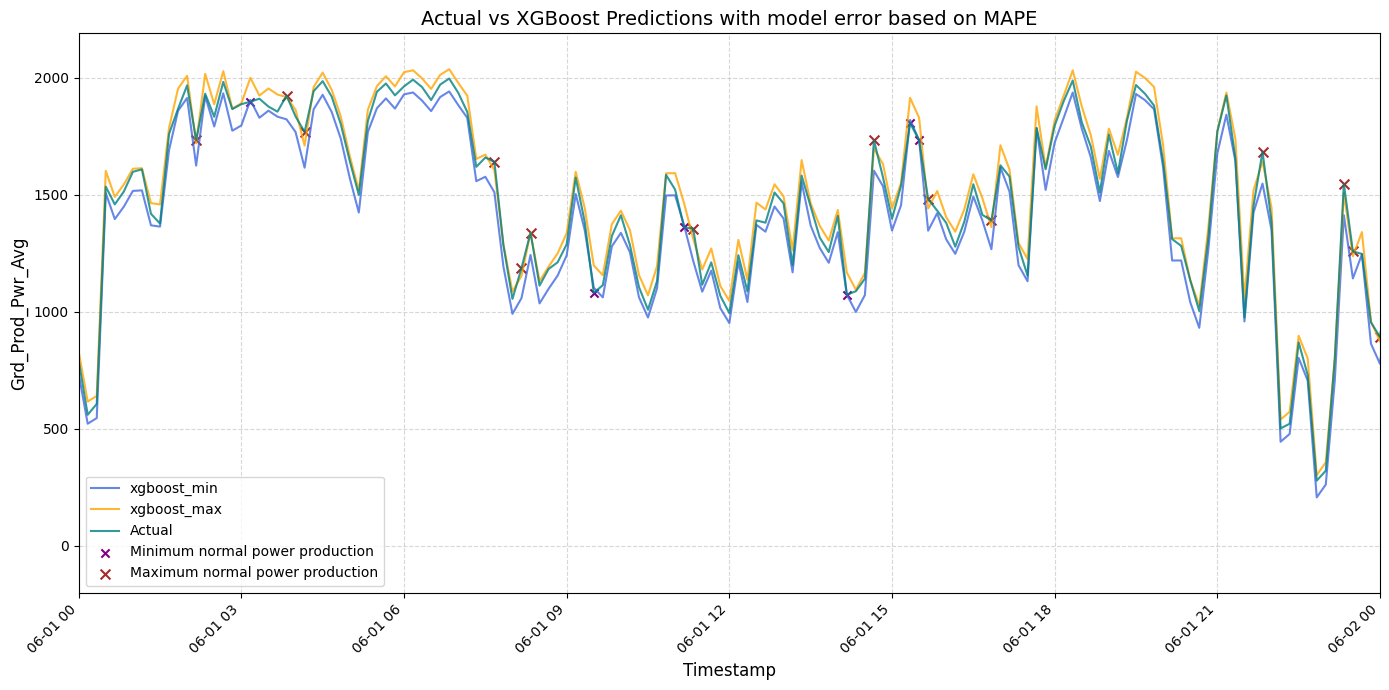

In [340]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define min and max bounds using xgboost predictions
merged_df_filtered17_sorted["xgboost_min"] = merged_df_filtered17_sorted["xgboost_pred_2017"] -modelling_error
merged_df_filtered17_sorted["xgboost_max"] = merged_df_filtered17_sorted["xgboost_pred_2017"] +modelling_error


# Identify where actual values exceed bounds
merged_df_filtered17_sorted["below_min"] = (merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["xgboost_min"])
merged_df_filtered17_sorted["above_max"] = (merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["xgboost_max"])

# Start plotting
plt.figure(figsize=(14, 7))

# Plot min and max bounds
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_min"],
    color='royalblue', alpha=0.8, label='xgboost_min', linewidth=1.5
)

plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_max"],
    color='orange', alpha=0.8, label='xgboost_max', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted[target_column],
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

plt.scatter(
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["below_min"], "Timestamp"],
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["below_min"], target_column],
    color='purple', marker='x', s=35, label=f'Minimum normal power production'
)

plt.scatter(
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["above_max"], "Timestamp"],
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["above_max"], target_column],
    color='brown', marker='x', s=50, label=f'Maximum normal power production'
)


# Formatting
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-06-01'), pd.to_datetime('2017-06-02'))
plt.title("Actual vs XGBoost Predictions with model error based on MAPE", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


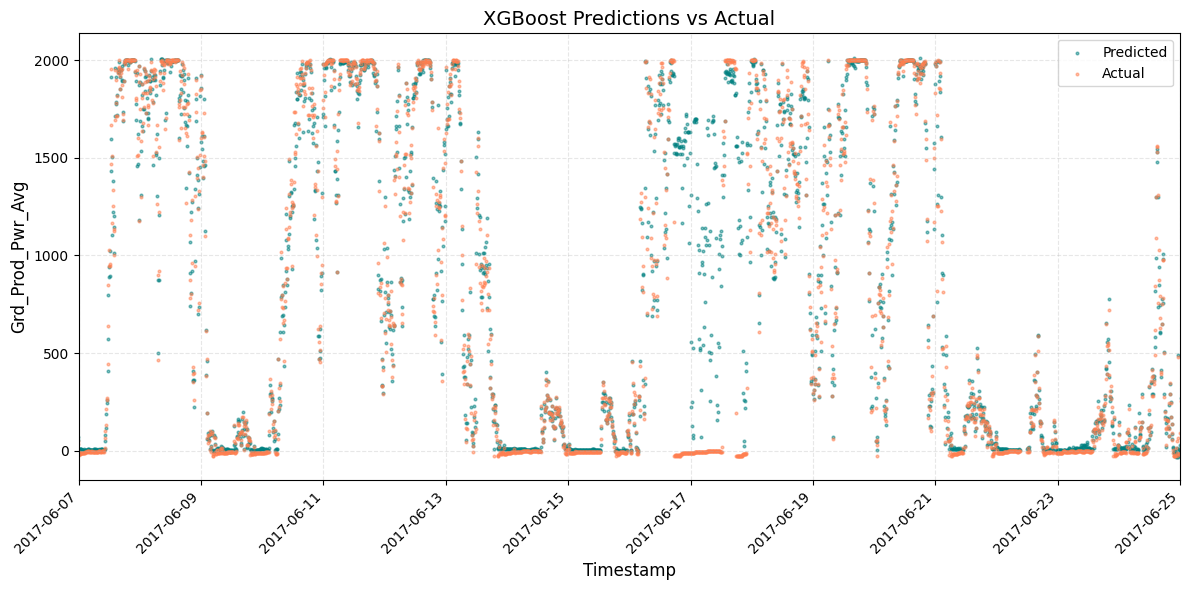

In [341]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Scatter plot for predicted values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    c='teal', alpha=0.5, label='Predicted', marker='.', s=15  # Adjusted size and transparency
)

# Scatter plot for actual values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    c='coral', alpha=0.5, label='Actual', marker='.', s=15  # Different marker and transparency
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)  # Subtle grid

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


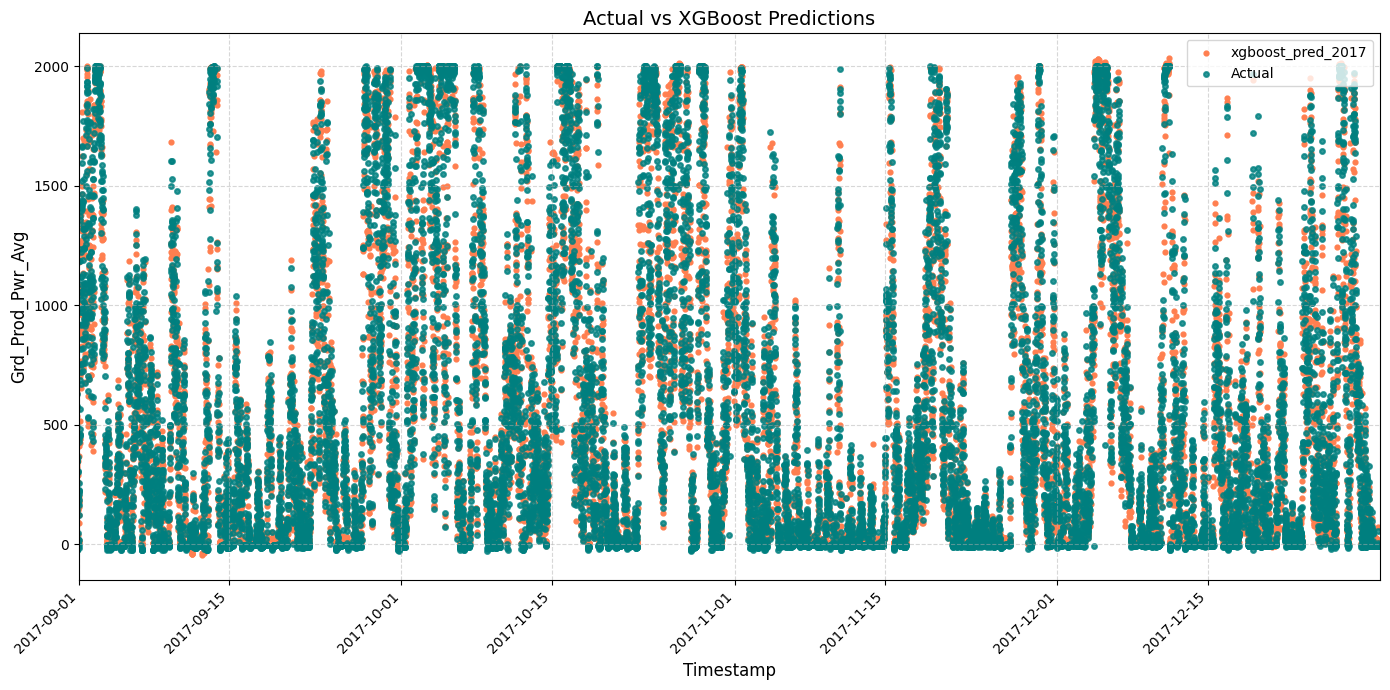

In [342]:
# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Start plotting
plt.figure(figsize=(14, 7))

# Scatter plot for xgboost predictions
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_pred_2017"],
    color='coral', marker='o', s=12, label='xgboost_pred_2017'
)

# Line plot for actual values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted[target_column],
    color='teal', alpha=0.8, s=12,label='Actual', linestyle='-', linewidth=1.5
)

# Formatting
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-09-01'), pd.to_datetime('2017-12-31'))
plt.title("Actual vs XGBoost Predictions", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Intervals:

In [343]:
# check units of the independent variables to make sure that interval is correctly chosen:
["Gen_Phase1_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Nac_Temp_Avg", "Avg_Humidity"]
# Get a statistical summary for the other columns

windspeed_summary = merged_df_filtered17_sorted["Avg_Windspeed1"].describe()
nac_temp_summary = merged_df_filtered17_sorted["Nac_Temp_Avg"].describe()
humidity_summary = merged_df_filtered17_sorted["Avg_Humidity"].describe()
print(f"Avg Windspeed Summary:\n{windspeed_summary}")
print(f"Nac Temp Avg Summary:\n{nac_temp_summary}")
print(f"Avg Humidity Summary:\n{humidity_summary}")


Avg Windspeed Summary:
count    34581.000000
mean         6.257465
std          3.527416
min          0.000000
25%          3.600000
50%          5.600000
75%          8.400000
max         23.100000
Name: Avg_Windspeed1, dtype: float64
Nac Temp Avg Summary:
count    34582.000000
mean        31.666994
std          5.829491
min         17.000000
25%         28.000000
50%         32.000000
75%         36.000000
max         50.000000
Name: Nac_Temp_Avg, dtype: float64
Avg Humidity Summary:
count    34582.000000
mean        63.366694
std         17.430912
min         11.000000
25%         51.000000
50%         65.000000
75%         77.000000
max         99.000000
Name: Avg_Humidity, dtype: float64


In [344]:
# Define intervals for each feature
Amb_Temp_interval = [-0.15, 0.15]         # degrees (for Amb_Temp_Avg)
Gen_RPM_interval = [-0.005, 0.005]          # RPM (for Gen_RPM_Avg)
Windspeed_interval = [-0.3, 0.3]        # m/s (for Amb_WindSpeed_Avg)
Humidity_interval = [-1.5, 1.5]     # percentage (for Avg_Humidity)
Pressure_interval = [-0.3, 0.3]         # hPa (for Avg_Pressure)

In [345]:
# Calculate maximum values by adding the max of each interval to the average values
merged_df_filtered17_sorted["max_Amb_Temp_Avg"] = merged_df_filtered17_sorted["Amb_Temp_Avg"] + max(Amb_Temp_interval)
merged_df_filtered17_sorted["max_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + max(Gen_RPM_interval)
merged_df_filtered17_sorted["max_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] + max(Windspeed_interval)
merged_df_filtered17_sorted["max_Avg_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] + max(Humidity_interval)
merged_df_filtered17_sorted["max_Avg_Pressure"] = merged_df_filtered17_sorted["Avg_Pressure"] + max(Pressure_interval)

# Calculate minimum values by adding the min of each interval to the average values
merged_df_filtered17_sorted["min_Amb_Temp_Avg"] = merged_df_filtered17_sorted["Amb_Temp_Avg"] - min(Amb_Temp_interval)
merged_df_filtered17_sorted["min_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] - min(Gen_RPM_interval)
merged_df_filtered17_sorted["min_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] - min(Windspeed_interval)
merged_df_filtered17_sorted["min_Avg_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] - min(Humidity_interval)
merged_df_filtered17_sorted["min_Avg_Pressure"] = merged_df_filtered17_sorted["Avg_Pressure"] - min(Pressure_interval)


In [346]:
print(model.get_booster().feature_names)

['Avg_Pressure', 'Avg_Humidity', 'Amb_Temp_Avg', 'Gen_RPM_Avg', 'Amb_WindSpeed_Avg']


In [347]:
merged_df["Avg_Pressure"]

0        1005
1        1005
2        1005
3        1006
4        1005
         ... 
35765    1018
35766    1002
35767    1002
35768    1003
35769    1003
Name: Avg_Pressure, Length: 35770, dtype: int64

### migght do this instead later:

Amb_Temp_interval = [-0.5, 0.5]    # degrees (for Amb_Temp_Avg)
Windspeed_interval = [-1, 1]       # m/s (for Amb_WindSpeed_Avg)
Humidity_interval = [-0.5, 0.5]    # percentage (for Avg_Humidity)
Pressure_interval = [-1, 1]        # hPa? (for Avg_Pressure)

In [348]:
import pandas as pd
import itertools

# Define intervals for each feature
Amb_Temp_interval = [-0.15, 0.15]         # degrees (for Amb_Temp_Avg)
Gen_RPM_interval = [-0.005, 0.005]          # RPM (for Gen_RPM_Avg)
Windspeed_interval = [-0.3, 0.3]        # m/s (for Amb_WindSpeed_Avg)
Humidity_interval = [-1.5, 1.5]     # percentage (for Avg_Humidity)
Pressure_interval = [-0.3, 0.3]         # hPa (for Avg_Pressure)



# Generate all 32 combinations of interval adjustments
combinations = list(itertools.product(
    Amb_Temp_interval,
    Gen_RPM_interval,
    Windspeed_interval,
    Humidity_interval,
    Pressure_interval
))

# Iterate through the 32 combinations
for idx, combo in enumerate(combinations):
    Amb_Temp_val, Gen_RPM_val, WindSpeed_val, Humidity_val, Pressure_val = combo

    # Apply the combination adjustments to the time series
X_test = pd.DataFrame({
    'Amb_Temp_Avg': merged_df_filtered17_sorted["Amb_Temp_Avg"] + Amb_Temp_val,
    'Gen_RPM_Avg': merged_df_filtered17_sorted["Gen_RPM_Avg"] + Gen_RPM_val,
    'Amb_WindSpeed_Avg': merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] + WindSpeed_val,
    'Avg_Humidity': merged_df_filtered17_sorted["Avg_Humidity"] + Humidity_val,
    'Avg_Pressure': merged_df_filtered17_sorted["Avg_Pressure"] + Pressure_val
})

# Ensure the order of columns matches the training set
X_test = X_test[feature_columns]  # This fixes the issue

# Predict with the model for the entire time series
predictions = model.predict(X_test)

# Store predictions in the DataFrame
merged_df_filtered17_sorted[f'pred_comb_{idx+1}'] = predictions

print(f"Combination {idx+1}: Prediction completed for the entire time series.")


# Optionally, save or visualize the modified DataFrame
# merged_df_filtered17_sorted.to_csv('predictions_with_combinations.csv', index=False)


Combination 32: Prediction completed for the entire time series.


## Only sensor error:

C:\Users\thors\AppData\Local\Temp\ipykernel_30428\8437922.py:49: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)  # Adjusts the number of x-axis labels


(np.float64(17324.0), np.float64(17342.0))

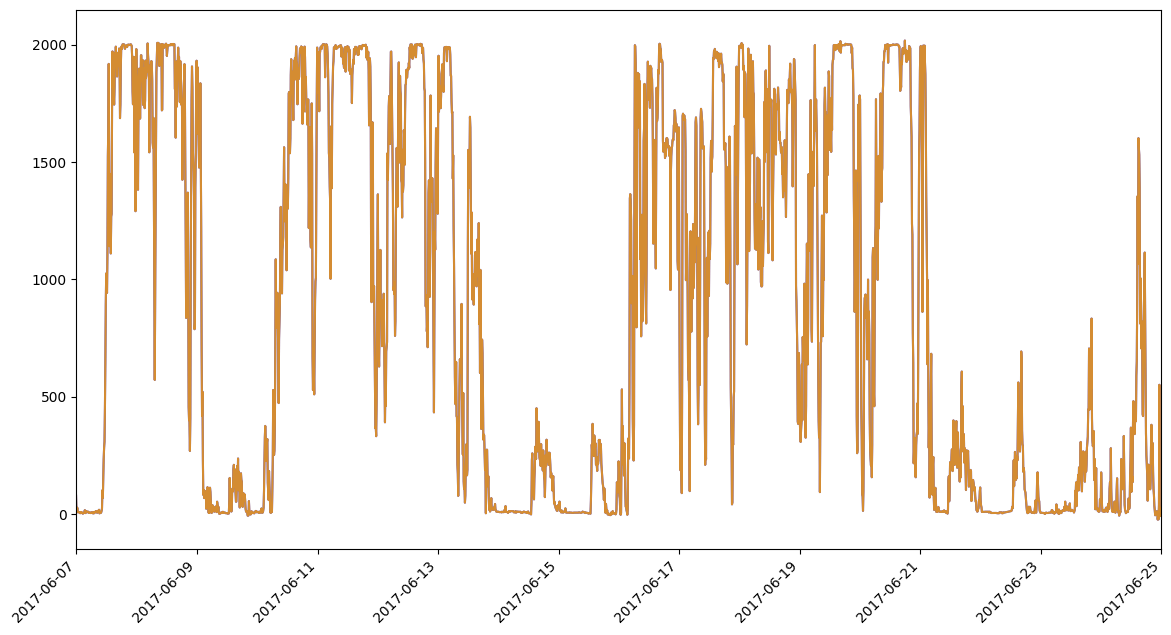

In [349]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort DataFrame by Timestamp for chronological order
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Plot min and max predictions over time
plt.figure(figsize=(14, 7))

# Shaded area between min and max predictions for clarity
plt.fill_between(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    merged_df_filtered17_sorted["row_max"], 
    color='gray', alpha=0.3, label="Prediction Range"
)

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Set x-axis labels to be more readable
plt.xticks(rotation=45, ha='right')

# Reduce the number of x-axis ticks for better readability
plt.locator_params(axis='x', nbins=10)  # Adjusts the number of x-axis labels

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

#


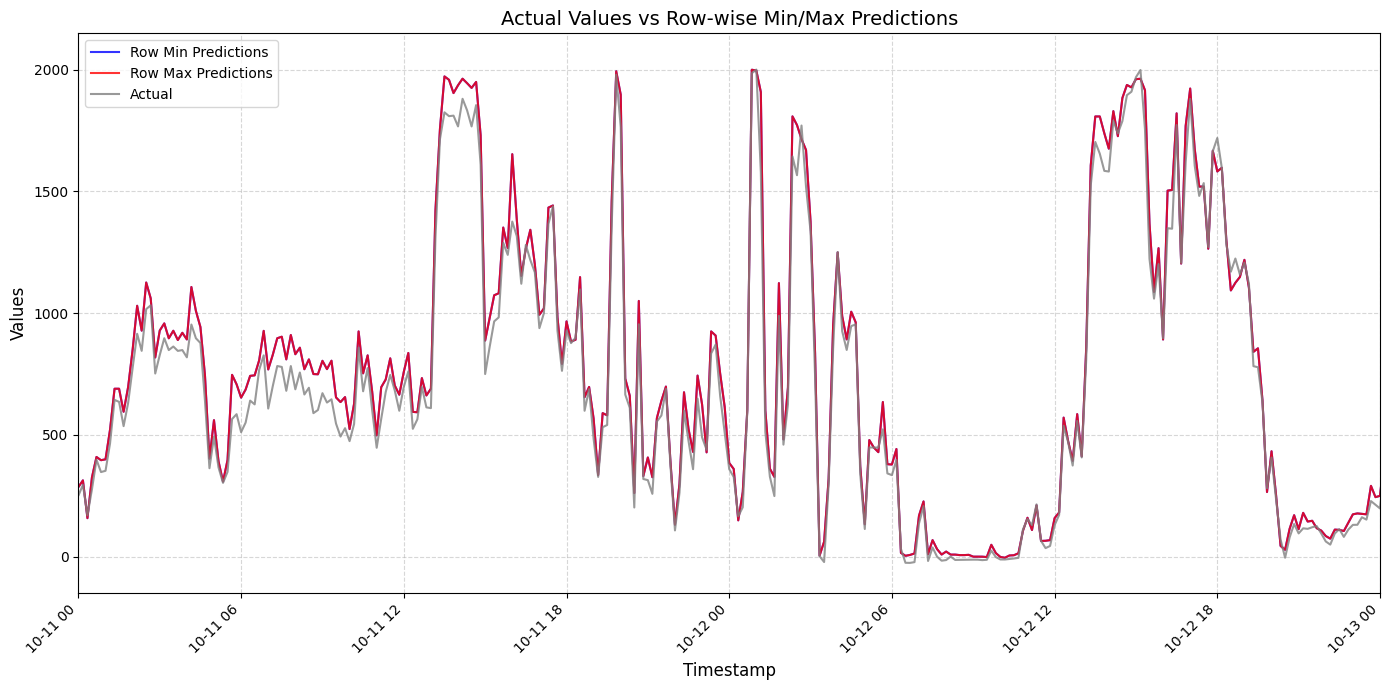

In [350]:


# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp for proper chronological plotting
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Define interval for x-axis if needed (adjust start and end dates)
plt.xlim(pd.to_datetime('2017-10-11'), pd.to_datetime('2017-10-13'))

# Title and labels
plt.title("Actual Values vs Row-wise Min/Max Predictions", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Values", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


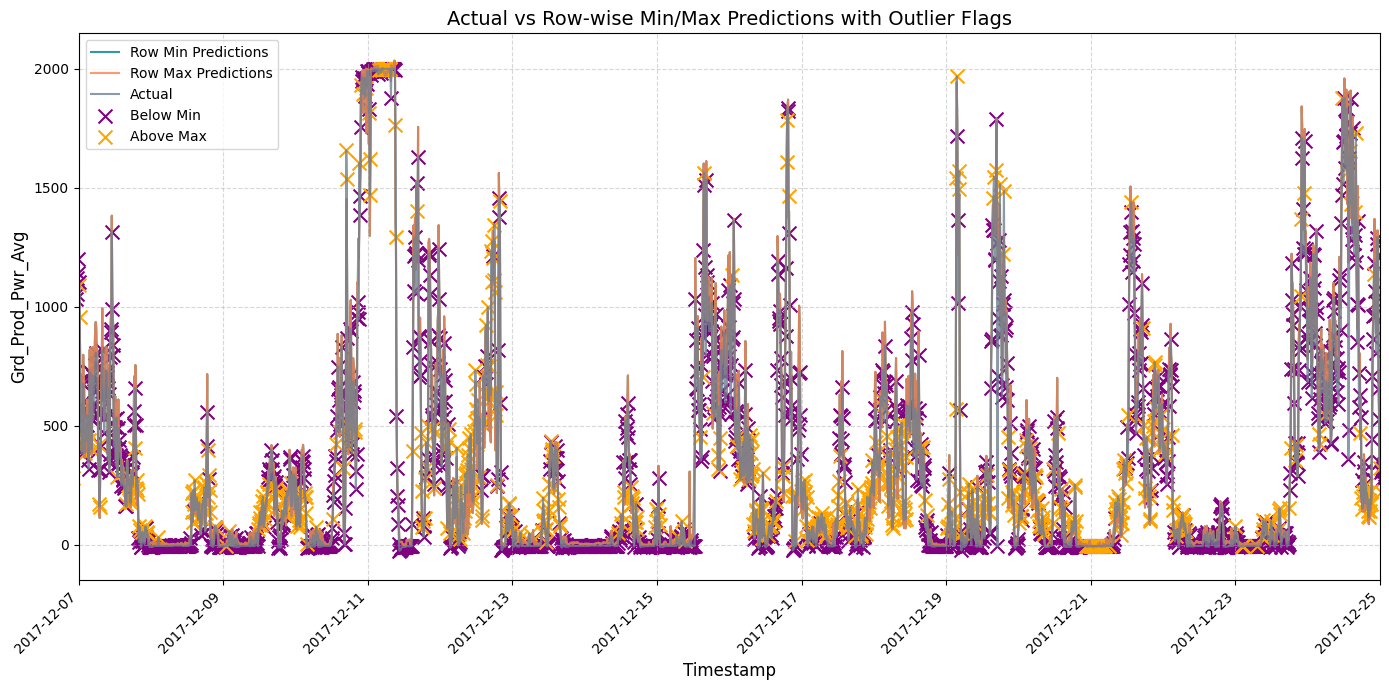

In [351]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)



# Flag where actual values are outside the row-wise min and max
merged_df_filtered17_sorted["below_min"] = (merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["row_min"]).astype(int)
merged_df_filtered17_sorted["above_max"] = (merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["row_max"]).astype(int)



# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='teal', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='coral', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='slategrey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label='Below Min'
)

# Scatter points where actual is above row_max
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label='Above Max'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-12-07'), pd.to_datetime('2017-12-25'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Outlier Flags", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


## Adjust maximum power production here:

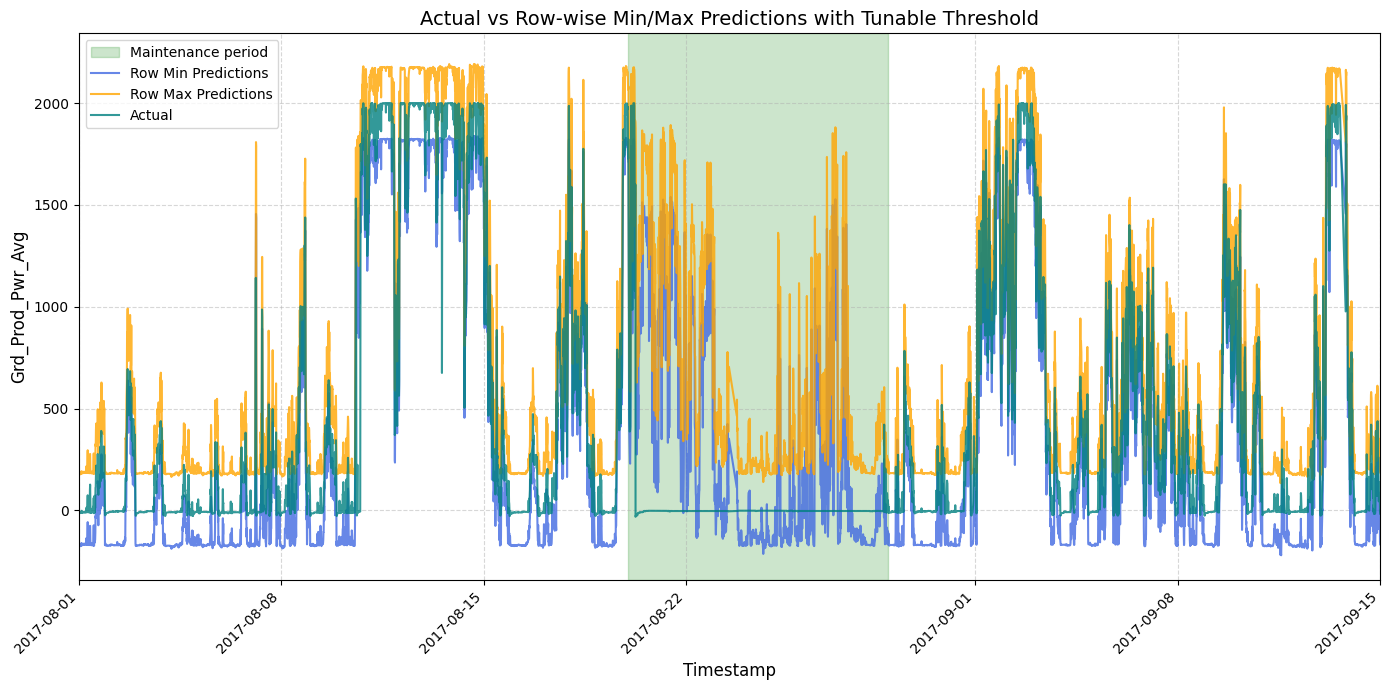

In [352]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - modelling_error_xgboost)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + modelling_error_xgboost)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Add green shaded region between specified dates
plt.axvspan(pd.to_datetime('2017-08-20'), pd.to_datetime('2017-08-29'), color='green', alpha=0.2, label="Maintenance period")

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"] - modelling_error_xgboost, 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"] + modelling_error_xgboost, 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

"""# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='coral', marker='x', s=50, label=f'Below Min - {threshold}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Above Max + {threshold}'
)"""

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-08-01'), pd.to_datetime('2017-09-15'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [353]:
"""import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")



# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)


# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - modelling_error_xgboost)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + modelling_error_xgboost)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"]-modelling_error_xgboost, 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"]+modelling_error_xgboost, 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=50, label=f'Minimum normal power production'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Maximum normal power production '
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-15'), pd.to_datetime('2017-06-17'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()
"""

'import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Ensure Timestamp column is in datetime format\nmerged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])\n\n# Sort the DataFrame by Timestamp\nmerged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")\n\n\n\n# Identify prediction columns\nprediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith(\'pred_comb_\')]\n\n# Ensure prediction columns are numeric\nmerged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors=\'coerce\')\n\n# Compute row-wise min and max for prediction columns\nmerged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)\nmerged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)\n\n\n# Flag where actual values are outside the row-wise min and max with a thres

In [354]:
modelling_error_xgboost

np.float64(176.44745807439782)

In [355]:
"""import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")


# Identify prediction columns generated by the hybrid model (e.g., hybrid_pred_comb_1, hybrid_pred_comb_2, ...)
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for the hybrid model predictions
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - modelling_error_xgboost)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + modelling_error_xgboost)
).astype(int)

# Plotting the results
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"] - modelling_error_xgboost, 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"] + modelling_error_xgboost, 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values (target column)
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold (anomalies below the minimum)
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label='Below Minimum Power Production'
)

# Scatter points where actual is above row_max + threshold (anomalies above the maximum)
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label='Above Maximum Power Production'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-08-02'), pd.to_datetime('2017-09-03'))  # Example date range

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust layout to prevent clipping
plt.tight_layout()  
plt.show()
"""

'import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Ensure Timestamp column is in datetime format\nmerged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])\n\n# Sort the DataFrame by Timestamp\nmerged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")\n\n\n# Identify prediction columns generated by the hybrid model (e.g., hybrid_pred_comb_1, hybrid_pred_comb_2, ...)\nprediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith(\'pred_comb_\')]\n\n# Ensure prediction columns are numeric\nmerged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors=\'coerce\')\n\n# Compute row-wise min and max for the hybrid model predictions\nmerged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)\nmerged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max

In [356]:
[col for col in merged_df_filtered17_sorted.columns if col.startswith('hybrid_pred_comb_')]

[]

In [357]:
merged_df_filtered17_sorted[prediction_columns].max(axis=1) 

52211    394.576233
12009    354.043243
81550    380.092865
32490    372.125153
5835     293.624969
            ...    
30058    566.280090
57112    446.791382
9296     170.703934
84976    155.087387
22499    260.535187
Length: 34582, dtype: float32

## XGBoost model plotting

In [358]:
"""# Checking other dates of the year when the turbine generator is in healthy condition:

import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
# Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for sensor variational error
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1) - (modelling_error)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1) + (modelling_error)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] )
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] )
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label=f'Minimum normal power production', alpha=0.6
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=35, label=f'Maximum normal power production', alpha=0.6
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-10'), pd.to_datetime('2017-06-15'))


# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions (XGBoost)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()
"""

'# Checking other dates of the year when the turbine generator is in healthy condition:\n\nimport matplotlib.pyplot as plt\nimport pandas as pd\n\n# Ensure Timestamp column is in datetime format\nmerged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])\n\n# Sort the DataFrame by Timestamp\nmerged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")\n\n# Define tunable threshold\n# Change this value as needed (e.g., 2 means >2 above max or <-2 below min)\n\n# Identify prediction columns\nprediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith(\'pred_comb_\')]\n\n# Ensure prediction columns are numeric\nmerged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors=\'coerce\')\n\n# Compute row-wise min and max for sensor variational error\nmerged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_colum

In [359]:
"""import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute sensor variation (based on deviation from actual prediction)
sensor_min_deviation = (merged_df_filtered17_sorted[prediction_columns].min(axis=1) - merged_df_filtered17_sorted[target_column]).abs()
sensor_max_deviation = (merged_df_filtered17_sorted[prediction_columns].max(axis=1) - merged_df_filtered17_sorted[target_column]).abs()

# Combine modelling error and sensor variation using root-sum-square (RSS)
row_min_deviation = np.sqrt(sensor_min_deviation**2 + modelling_error**2)
row_max_deviation = np.sqrt(sensor_max_deviation**2 + modelling_error**2)

# Final row-wise bounds
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[target_column] - row_min_deviation
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[target_column] + row_max_deviation

# Flag where actual values are outside the bounds
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["row_min"]
).astype(int)

merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["row_max"]
).astype(int)

# Plotting
plt.figure(figsize=(14, 7))

plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label='Minimum normal power production', alpha=0.3
)

plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=35, label='Maximum normal power production', alpha=0.3
)

plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-06-10'), pd.to_datetime('2017-06-15'))

plt.title("Actual vs Row-wise Min/Max Predictions (XGBoost)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
"""

'import matplotlib.pyplot as plt\nimport pandas as pd\nimport numpy as np\n\n# Ensure Timestamp column is in datetime format\nmerged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])\n\n# Sort the DataFrame by Timestamp\nmerged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")\n\n# Identify prediction columns\nprediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith(\'pred_comb_\')]\nmerged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors=\'coerce\')\n\n# Compute sensor variation (based on deviation from actual prediction)\nsensor_min_deviation = (merged_df_filtered17_sorted[prediction_columns].min(axis=1) - merged_df_filtered17_sorted[target_column]).abs()\nsensor_max_deviation = (merged_df_filtered17_sorted[prediction_columns].max(axis=1) - merged_df_filtered17_sorted[target_column]).abs()\n\n# Combine modellin

In [360]:
"""import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")



# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Define actual values
timestamps = merged_df_filtered17_sorted["Timestamp"]
actual_values = merged_df_filtered17_sorted[target_column]
upper_bound = merged_df_filtered17_sorted["row_max"] + modelling_error
# Start plotting
plt.figure(figsize=(14, 7))

# Plot row-wise min and max thresholds
plt.plot(timestamps, merged_df_filtered17_sorted["row_min"] - modelling_error, color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5)
plt.plot(timestamps, upper_bound, color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5)

# Dynamically change color of the actual line
prev_above = False
for i in range(len(timestamps) - 1):
    current_above = actual_values.iloc[i] > upper_bound.iloc[i]
    
    if i == 0 or current_above != prev_above:
        plt.plot(
            timestamps[i : i + 2], 
            actual_values.iloc[i : i + 2], 
            color='blue' if current_above else 'teal', 
            linewidth=1.5
        )
    else:
        plt.plot(
            timestamps[i : i + 2], 
            actual_values.iloc[i : i + 2], 
            color='red' if current_above else 'slategrey', 
            linewidth=1.5
        )
    
    prev_above = current_above

# Formatting
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
"""

'import matplotlib.pyplot as plt\nimport pandas as pd\nimport numpy as np\n\n# Ensure Timestamp column is in datetime format\nmerged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])\n\n# Sort the DataFrame by Timestamp\nmerged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")\n\n\n\n# Identify prediction columns\nprediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith(\'pred_comb_\')]\n\n# Ensure prediction columns are numeric\nmerged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors=\'coerce\')\n\n# Compute row-wise min and max for prediction columns\nmerged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)\nmerged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)\n\n# Define actual values\ntimestamps = merged_df_filtered17_

### Start: Plots without sensor error

In [361]:
"""import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define the XGBoost prediction column (without sensor variations)
xgboost_pred_column = "xgboost_pred_2017"

# Compute row-wise min and max **only based on modeling error**
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[xgboost_pred_column] - (modelling_error)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[xgboost_pred_column] + (modelling_error)

# Flag where actual values are outside the row-wise min and max with the threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["row_min"]
).astype(int)

merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["row_max"]
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label=f'Below Model Prediction Range'
)

# Scatter points where actual is above row_max
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Above Model Prediction Range'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.title("Actual vs Row-wise Min/Max Predictions from Modelling Error, ML model", fontsize=14)
# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-09-22'), pd.to_datetime('2017-09-24'))

"""

'import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Ensure Timestamp column is in datetime format\nmerged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])\n\n# Sort the DataFrame by Timestamp\nmerged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")\n\n# Define the XGBoost prediction column (without sensor variations)\nxgboost_pred_column = "xgboost_pred_2017"\n\n# Compute row-wise min and max **only based on modeling error**\nmerged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[xgboost_pred_column] - (modelling_error)\nmerged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[xgboost_pred_column] + (modelling_error)\n\n# Flag where actual values are outside the row-wise min and max with the threshold\nmerged_df_filtered17_sorted["below_min"] = (\n    merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["row_min"]\n).astype(int)\n\nmerged_df_filtered17_sorted["

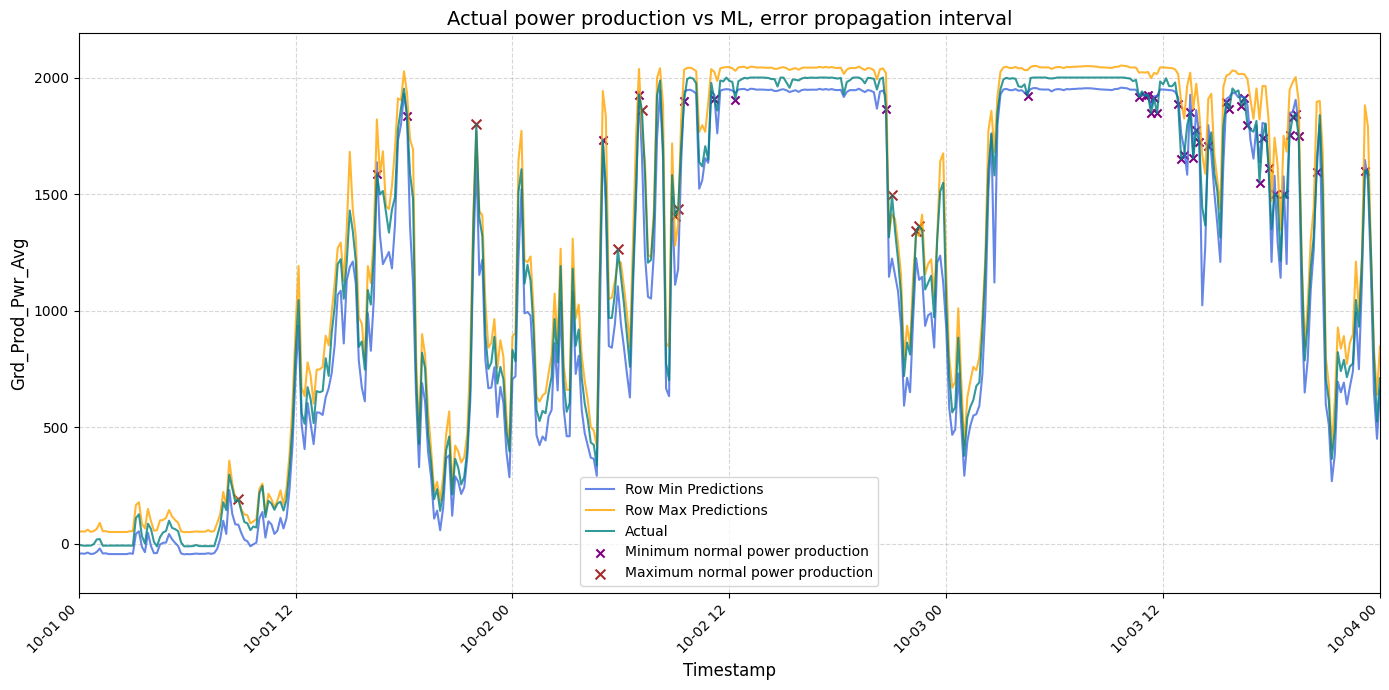

In [362]:
# Checking other dates of the year when the turbine generator is in healthy condition:

import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
# Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Calculate deviation from actual prediction, then apply RSS with modelling error
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted["xgboost_pred_2017"] - np.sqrt((merged_df_filtered17_sorted["xgboost_pred_2017"] - merged_df_filtered17_sorted[prediction_columns].min(axis=1))**2 + modelling_error**2)

merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted["xgboost_pred_2017"] + np.sqrt((merged_df_filtered17_sorted[prediction_columns].max(axis=1) - merged_df_filtered17_sorted["xgboost_pred_2017"])**2 + modelling_error**2)


# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"])
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"])
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label=f'Minimum normal power production'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Maximum normal power production'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-4'))


# Title and labels
plt.title("Actual power production vs ML, error propagation interval", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


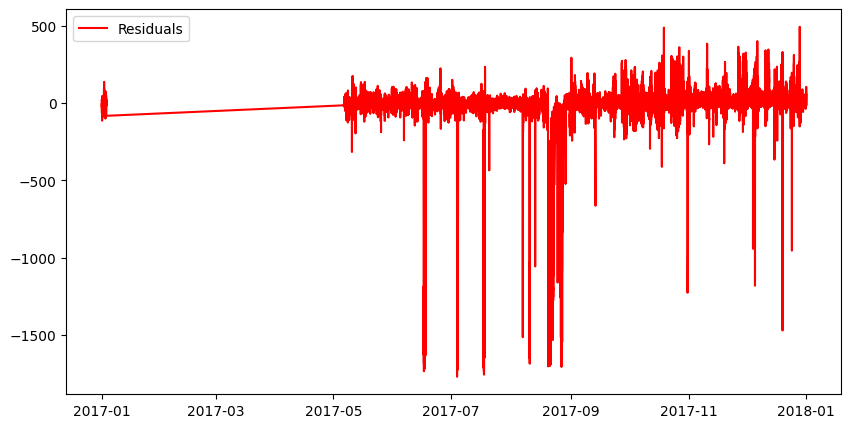

In [363]:
# Compute the modeling error dynamically (e.g., standard deviation of residuals)
residuals = merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["xgboost_pred_2017"]
modelling_error = residuals.std()  # or any other metric like mean absolute error (MAE)

plt.plot(merged_df_filtered17_sorted["Timestamp"], residuals, color="red", label="Residuals")
plt.legend()


## Analysis of anomalies

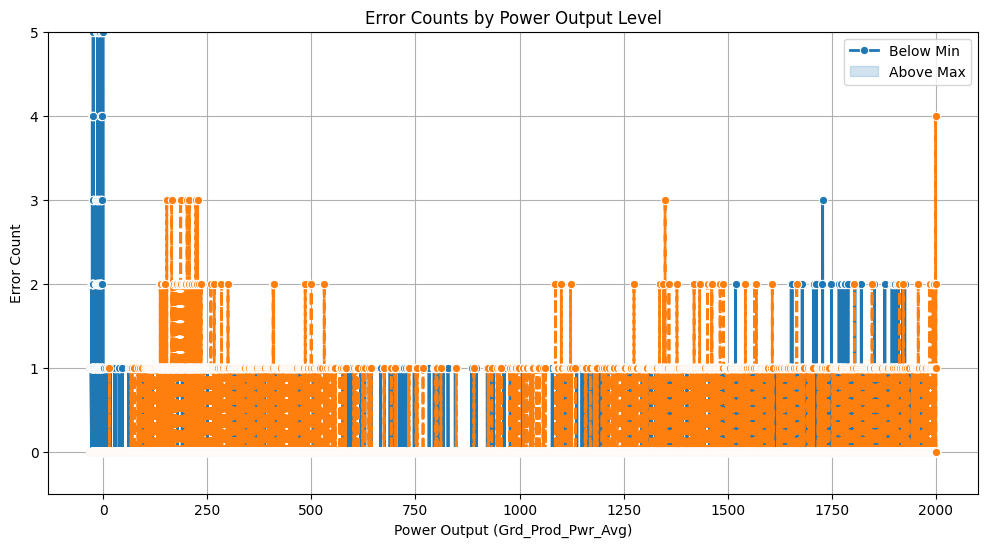

In [364]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute residual errors
merged_df_filtered17_sorted["residual"] = (
    merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["xgboost_pred_2017"]
)

# Count errors (above_max and below_min) by power level
error_counts = merged_df_filtered17_sorted.groupby(target_column)[["below_min", "above_max"]].sum()

# Plot the error counts against power levels
plt.figure(figsize=(12, 6))
sns.lineplot(data=error_counts, marker="o", linewidth=2)
plt.xlabel("Power Output (Grd_Prod_Pwr_Avg)")
plt.ylabel("Error Count")
plt.title("Error Counts by Power Output Level")
plt.legend(["Below Min", "Above Max"])
plt.grid(True)
plt.ylim(-0.5,5)
plt.show()


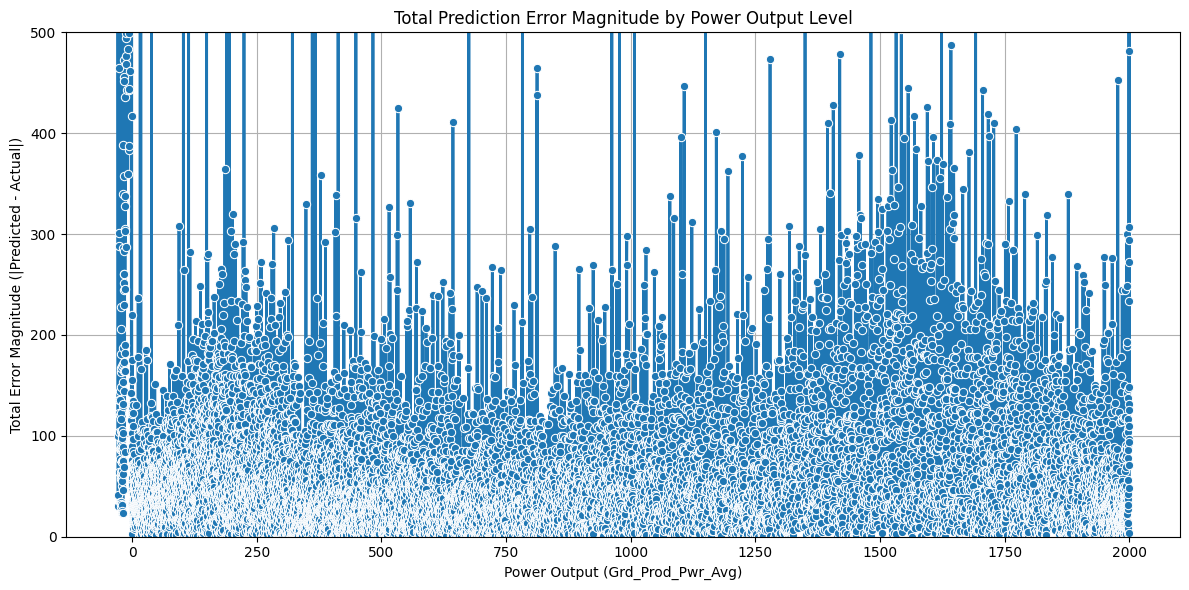

In [365]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute residual errors (difference between actual and predicted)
merged_df_filtered17_sorted["residual"] = (
    merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["xgboost_pred_2017"]
)

# Take absolute value of residuals to get error magnitude
merged_df_filtered17_sorted["abs_residual"] = merged_df_filtered17_sorted["residual"].abs()

# Group by power level and sum absolute residuals
error_magnitude_by_power = merged_df_filtered17_sorted.groupby(target_column)["abs_residual"].sum()

# Plot total error magnitude by power output
plt.figure(figsize=(12, 6))
sns.lineplot(data=error_magnitude_by_power, marker="o", linewidth=2)
plt.xlabel("Power Output (Grd_Prod_Pwr_Avg)")
plt.ylabel("Total Error Magnitude (|Predicted - Actual|)")
plt.title("Total Prediction Error Magnitude by Power Output Level")
plt.grid(True)
plt.ylim(0,500)
plt.tight_layout()
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_30428\3076003342.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_magnitude_by_power_bin = merged_df_filtered17_sorted.groupby("power_bin")["abs_residual"].sum()


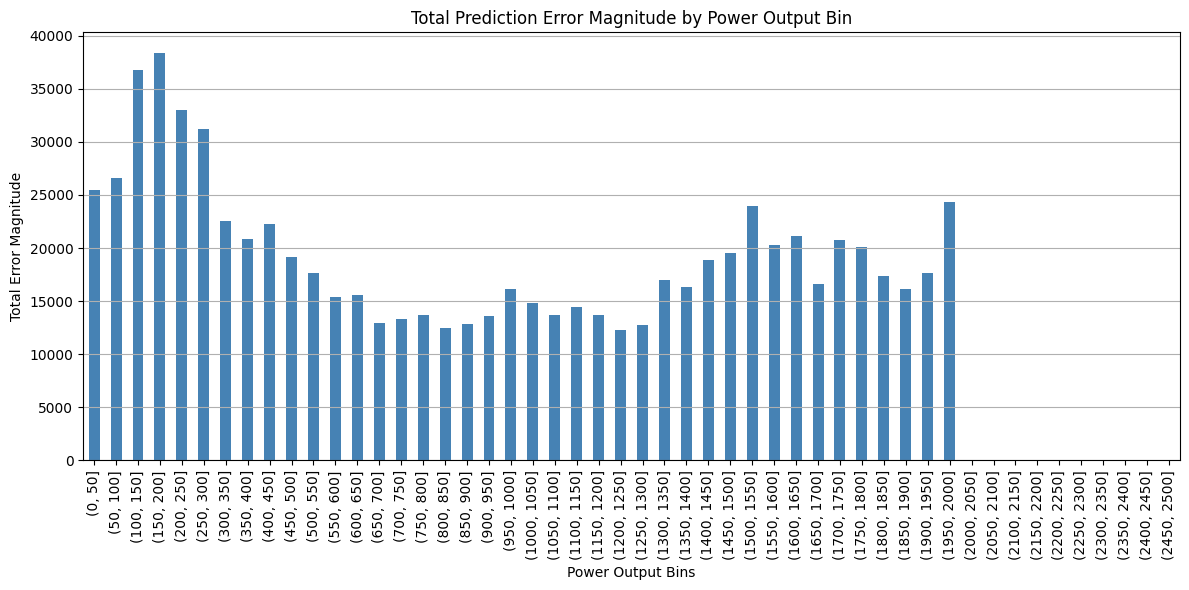

In [366]:
# Optional binning (e.g., 50 kW bins)
merged_df_filtered17_sorted["power_bin"] = pd.cut(
    merged_df_filtered17_sorted[target_column], bins=range(0, 2501, 50)
)

# Then group and plot as above
error_magnitude_by_power_bin = merged_df_filtered17_sorted.groupby("power_bin")["abs_residual"].sum()

plt.figure(figsize=(12, 6))
error_magnitude_by_power_bin.plot(kind='bar', color='steelblue')
plt.xlabel("Power Output Bins")
plt.ylabel("Total Error Magnitude")
plt.title("Total Prediction Error Magnitude by Power Output Bin")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


pd.to_datetime('2017-12-07'), pd.to_datetime('2017-12-15')

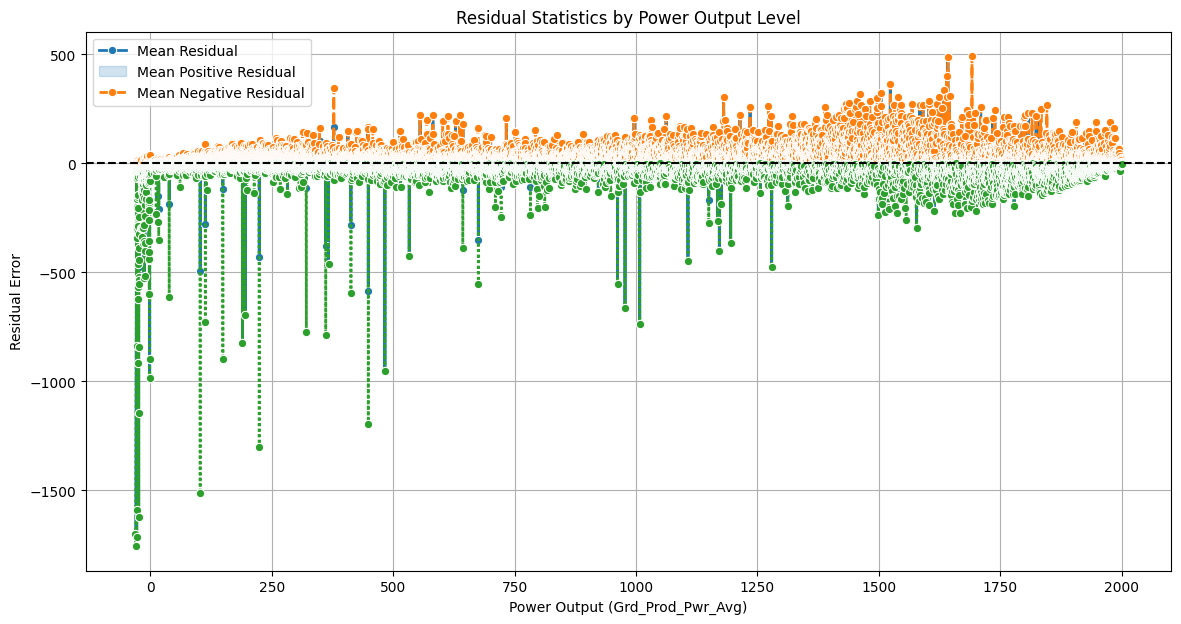

In [367]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Compute residual errors
merged_df_filtered17_sorted["residual"] = (
    merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["xgboost_pred_2017"]
)

# Group by power output level and calculate residual statistics
residual_stats = merged_df_filtered17_sorted.groupby(target_column)["residual"].agg(
    mean_residual="mean",
    std_residual="std",
    count="count"
)

# (Optional) Separate positive and negative residuals
positive_residuals = merged_df_filtered17_sorted[merged_df_filtered17_sorted["residual"] > 0]
negative_residuals = merged_df_filtered17_sorted[merged_df_filtered17_sorted["residual"] < 0]

positive_stats = positive_residuals.groupby(target_column)["residual"].agg(mean_positive="mean")
negative_stats = negative_residuals.groupby(target_column)["residual"].agg(mean_negative="mean")

# Merge them into one dataframe
residual_stats = residual_stats.join(positive_stats).join(negative_stats)

# Plot the mean residual and standard deviation
plt.figure(figsize=(14, 7))
sns.lineplot(data=residual_stats[["mean_residual", "mean_positive", "mean_negative"]], marker="o", linewidth=2)
plt.xlabel("Power Output (Grd_Prod_Pwr_Avg)")
plt.ylabel("Residual Error")
plt.title("Residual Statistics by Power Output Level")
plt.legend(["Mean Residual", "Mean Positive Residual", "Mean Negative Residual"])
plt.grid(True)
plt.axhline(0, color="black", linestyle="--")  # add a zero line
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_30428\133644193.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_pos = positive_residuals.groupby("power_bin")["residual"].mean()
C:\Users\thors\AppData\Local\Temp\ipykernel_30428\133644193.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_neg = negative_residuals.groupby("power_bin")["residual"].mean()


<Figure size 1400x600 with 0 Axes>

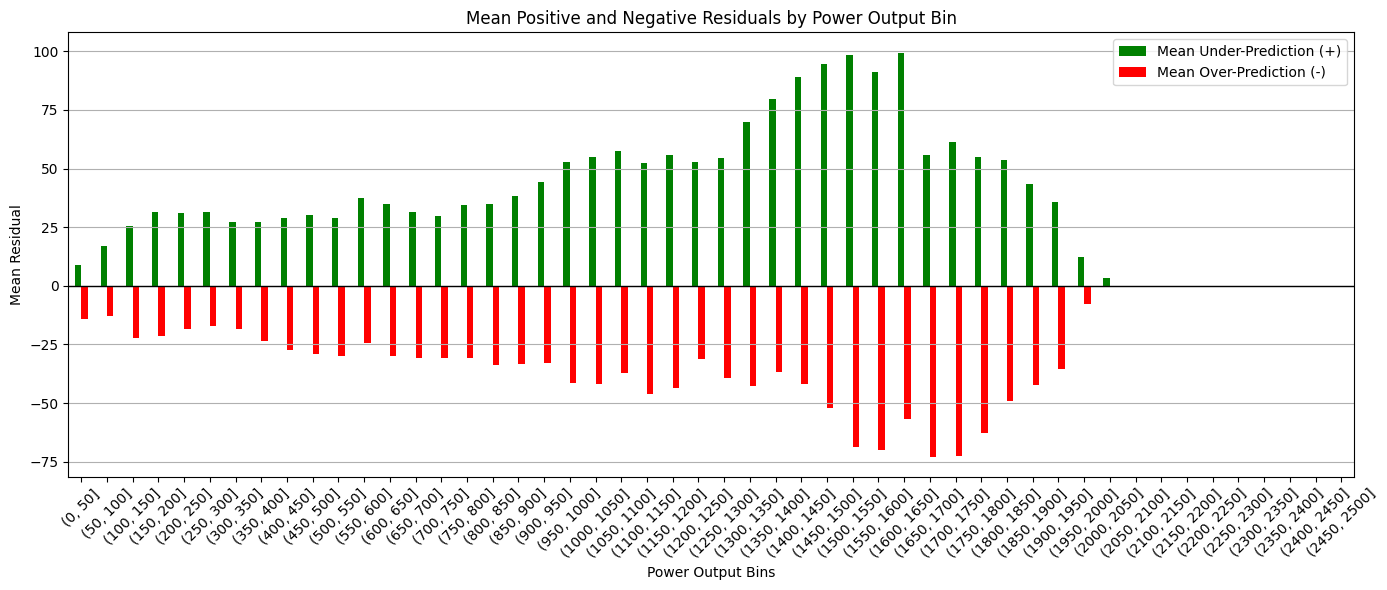

In [368]:
# Bin power output (e.g., 50 kW bins)
merged_df_filtered17_sorted["power_bin"] = pd.cut(
    merged_df_filtered17_sorted[target_column], bins=range(0, 2501, 50)
)

# Separate positive and negative residuals
positive_residuals = merged_df_filtered17_sorted[merged_df_filtered17_sorted["residual"] > 0]
negative_residuals = merged_df_filtered17_sorted[merged_df_filtered17_sorted["residual"] < 0]

# Group and compute mean for both
mean_pos = positive_residuals.groupby("power_bin")["residual"].mean()
mean_neg = negative_residuals.groupby("power_bin")["residual"].mean()

# Combine for plotting
residual_df = pd.DataFrame({
    "Mean Under-Prediction (+)": mean_pos,
    "Mean Over-Prediction (-)": mean_neg
})

# Plot
plt.figure(figsize=(14, 6))
residual_df.plot(kind='bar', figsize=(14,6), color=["green", "red"])
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Power Output Bins")
plt.ylabel("Mean Residual")
plt.title("Mean Positive and Negative Residuals by Power Output Bin")
plt.xticks(rotation=45)
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_30428\3088319624.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  anomaly_counts = merged_df_filtered17_sorted.groupby("power_bin")[["below_min", "above_max"]].sum()


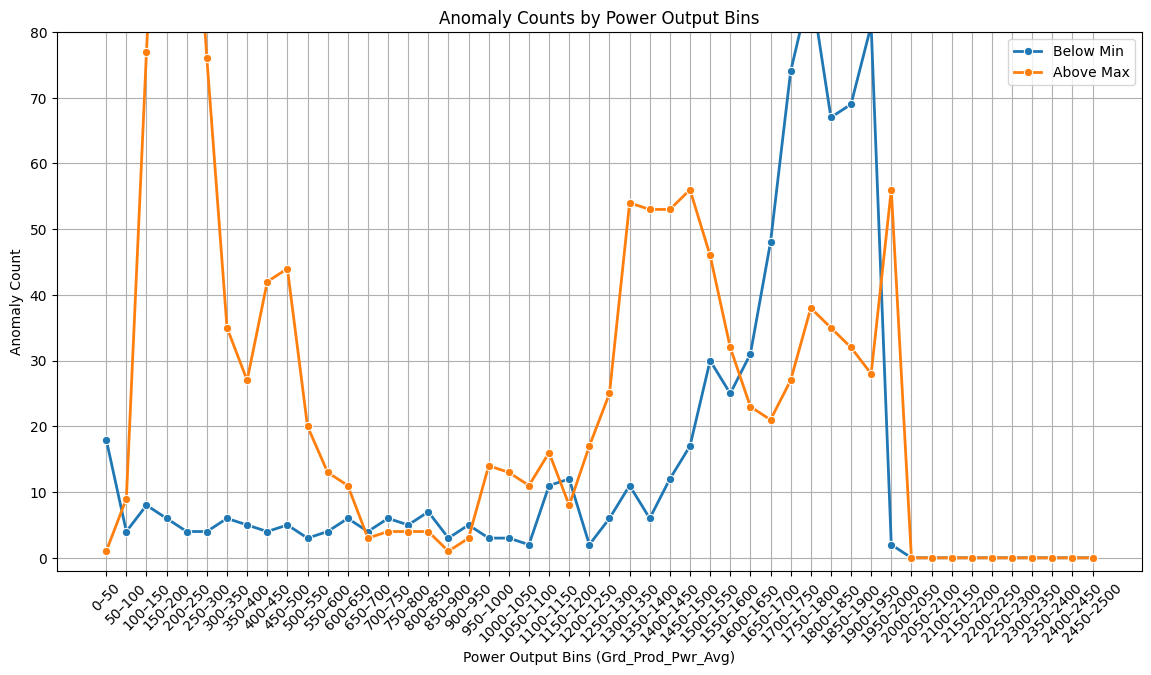

In [369]:
# Step 1: Reset the index
anomaly_counts = merged_df_filtered17_sorted.groupby("power_bin")[["below_min", "above_max"]].sum()

anomaly_counts_reset = anomaly_counts.reset_index()

# Step 2: Convert power_bin into string labels
anomaly_counts_reset["power_bin_str"] = anomaly_counts_reset["power_bin"].apply(lambda x: f"{int(x.left)}–{int(x.right)}")

# Step 3: Now plot using the new string labels
plt.figure(figsize=(14, 7))

sns.lineplot(
    x="power_bin_str", 
    y="below_min", 
    data=anomaly_counts_reset, 
    marker="o", 
    linewidth=2, 
    label="Below Min"
)
sns.lineplot(
    x="power_bin_str", 
    y="above_max", 
    data=anomaly_counts_reset, 
    marker="o", 
    linewidth=2, 
    label="Above Max"
)

plt.xlabel("Power Output Bins (Grd_Prod_Pwr_Avg)")
plt.ylabel("Anomaly Count")
plt.title("Anomaly Counts by Power Output Bins")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.ylim(-2, 80)
plt.show()


### Now for inference period:

C:\Users\thors\AppData\Local\Temp\ipykernel_30428\1041400802.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_df["residual"] = (


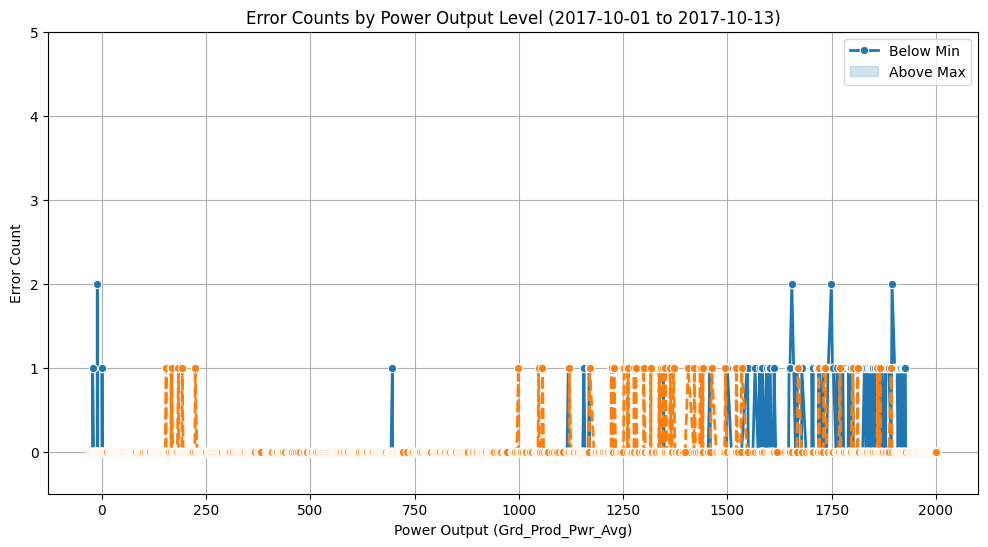

In [370]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the time window
start_date = "2017-10-01"
end_date = "2017-10-13"

# Filter the DataFrame by Timestamp
time_filtered_df = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= start_date) & 
    (merged_df_filtered17_sorted["Timestamp"] <= end_date)
]

# Compute residual errors within the time window
time_filtered_df["residual"] = (
    time_filtered_df[target_column] - time_filtered_df["xgboost_pred_2017"]
)

# Count errors (above_max and below_min) by power level within the time window
error_counts = time_filtered_df.groupby(target_column)[["below_min", "above_max"]].sum()

# Plot the error counts against power levels
plt.figure(figsize=(12, 6))
sns.lineplot(data=error_counts, marker="o", linewidth=2)
plt.xlabel("Power Output (Grd_Prod_Pwr_Avg)")
plt.ylabel("Error Count")
plt.title(f"Error Counts by Power Output Level ({start_date} to {end_date})")
plt.legend(["Below Min", "Above Max"])
plt.grid(True)
plt.ylim(-0.5, 5)
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_30428\3910594825.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_df["residual"] = time_filtered_df[target_column] - time_filtered_df["xgboost_pred_2017"]
C:\Users\thors\AppData\Local\Temp\ipykernel_30428\3910594825.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_df["abs_residual"] = time_filtered_df["residual"].abs()


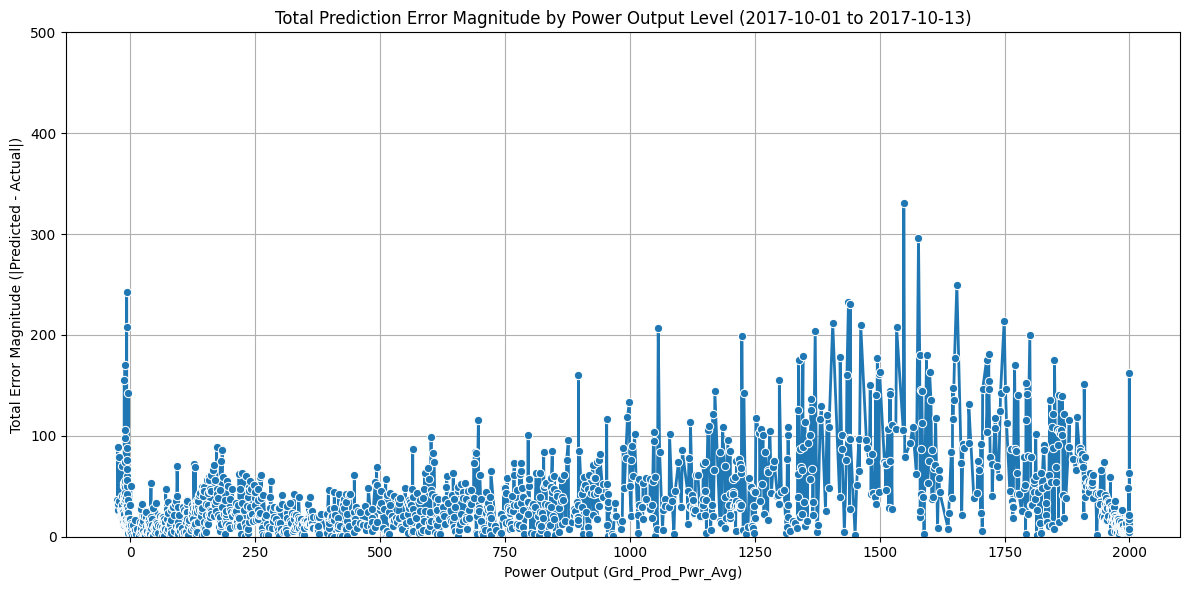

In [371]:
import seaborn as sns
import matplotlib.pyplot as plt

# Time filter
start_date = "2017-10-01"
end_date = "2017-10-13"
time_filtered_df = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= start_date) &
    (merged_df_filtered17_sorted["Timestamp"] <= end_date)
]

# Compute residuals
time_filtered_df["residual"] = time_filtered_df[target_column] - time_filtered_df["xgboost_pred_2017"]
time_filtered_df["abs_residual"] = time_filtered_df["residual"].abs()

# Group by power output
error_magnitude_by_power = time_filtered_df.groupby(target_column)["abs_residual"].sum()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=error_magnitude_by_power, marker="o", linewidth=2)
plt.xlabel("Power Output (Grd_Prod_Pwr_Avg)")
plt.ylabel("Total Error Magnitude (|Predicted - Actual|)")
plt.title(f"Total Prediction Error Magnitude by Power Output Level ({start_date} to {end_date})")
plt.grid(True)
plt.ylim(0, 500)
plt.tight_layout()
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_30428\924039631.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_df["residual"] = time_filtered_df[target_column] - time_filtered_df["xgboost_pred_2017"]
C:\Users\thors\AppData\Local\Temp\ipykernel_30428\924039631.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_df["abs_residual"] = time_filtered_df["residual"].abs()
C:\Users\thors\AppData\Local\Temp\ipykernel_30428\924039631.py:14: SettingWithCopyWarning: 
A value is trying to 

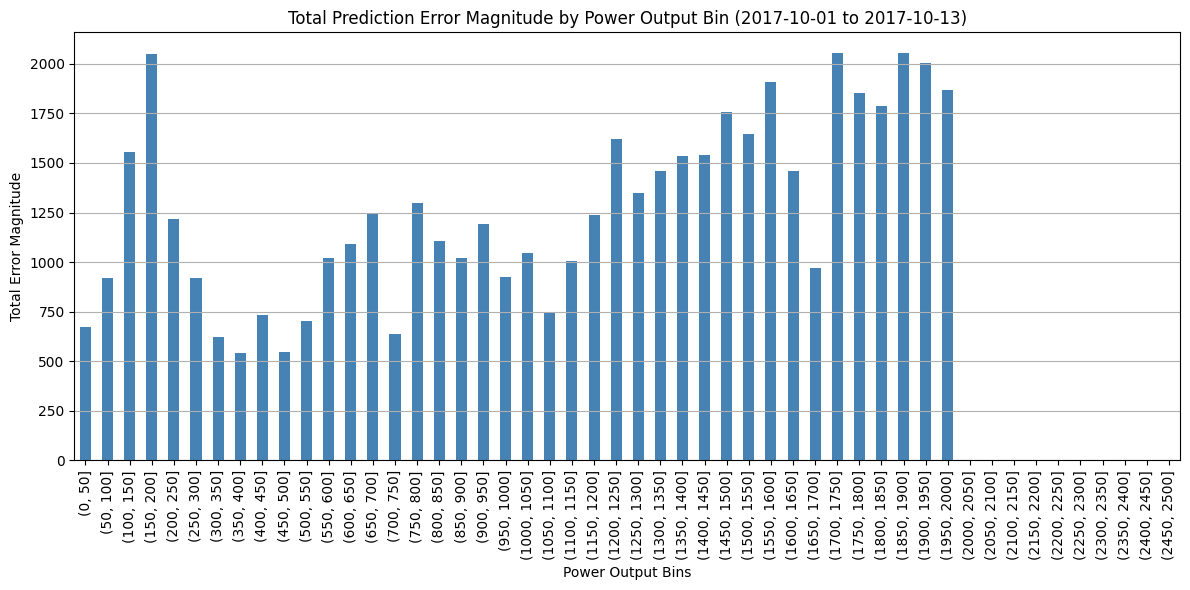

In [372]:
# Time filter
start_date = "2017-10-01"
end_date = "2017-10-13"
time_filtered_df = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= start_date) &
    (merged_df_filtered17_sorted["Timestamp"] <= end_date)
]

# Compute residuals
time_filtered_df["residual"] = time_filtered_df[target_column] - time_filtered_df["xgboost_pred_2017"]
time_filtered_df["abs_residual"] = time_filtered_df["residual"].abs()

# Bin power levels
time_filtered_df["power_bin"] = pd.cut(time_filtered_df[target_column], bins=range(0, 2501, 50))

# Group and plot
error_magnitude_by_power_bin = time_filtered_df.groupby("power_bin")["abs_residual"].sum()

plt.figure(figsize=(12, 6))
error_magnitude_by_power_bin.plot(kind='bar', color='steelblue')
plt.xlabel("Power Output Bins")
plt.ylabel("Total Error Magnitude")
plt.title(f"Total Prediction Error Magnitude by Power Output Bin ({start_date} to {end_date})")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_30428\2009701568.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_df["residual"] = time_filtered_df[target_column] - time_filtered_df["xgboost_pred_2017"]


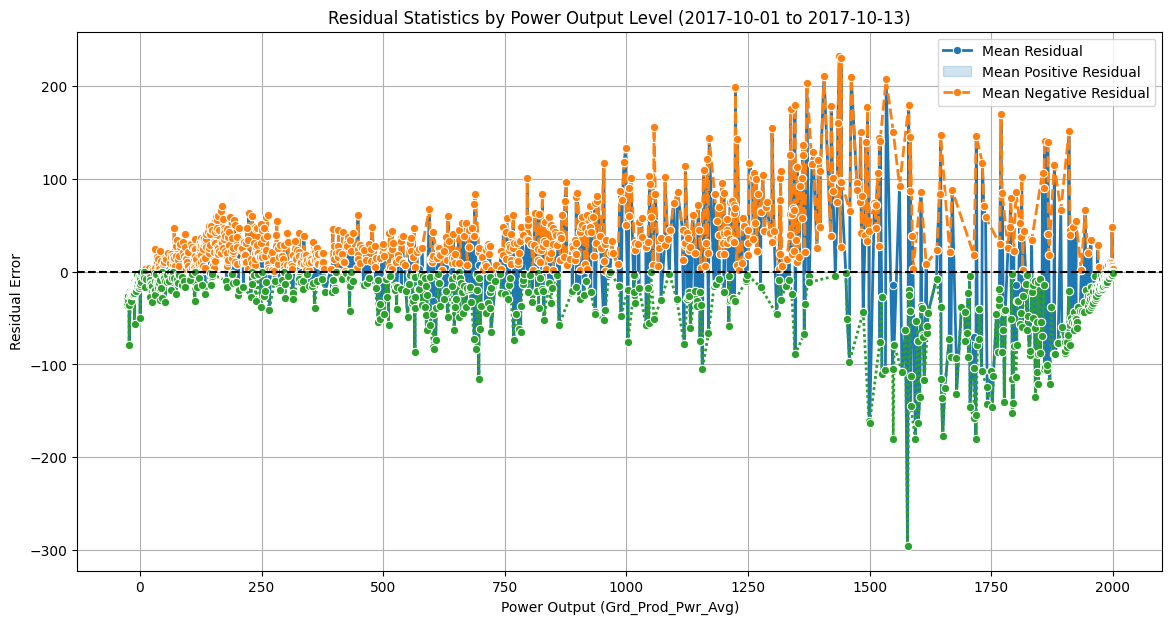

In [373]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Time filter
start_date = "2017-10-01"
end_date = "2017-10-13"
time_filtered_df = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= start_date) &
    (merged_df_filtered17_sorted["Timestamp"] <= end_date)
]

# Compute residuals
time_filtered_df["residual"] = time_filtered_df[target_column] - time_filtered_df["xgboost_pred_2017"]

# Stats
residual_stats = time_filtered_df.groupby(target_column)["residual"].agg(
    mean_residual="mean",
    std_residual="std",
    count="count"
)

positive_residuals = time_filtered_df[time_filtered_df["residual"] > 0]
negative_residuals = time_filtered_df[time_filtered_df["residual"] < 0]

positive_stats = positive_residuals.groupby(target_column)["residual"].agg(mean_positive="mean")
negative_stats = negative_residuals.groupby(target_column)["residual"].agg(mean_negative="mean")

residual_stats = residual_stats.join(positive_stats).join(negative_stats)

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(data=residual_stats[["mean_residual", "mean_positive", "mean_negative"]], marker="o", linewidth=2)
plt.xlabel("Power Output (Grd_Prod_Pwr_Avg)")
plt.ylabel("Residual Error")
plt.title(f"Residual Statistics by Power Output Level ({start_date} to {end_date})")
plt.legend(["Mean Residual", "Mean Positive Residual", "Mean Negative Residual"])
plt.grid(True)
plt.axhline(0, color="black", linestyle="--")
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_30428\2908255443.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_df["power_bin"] = pd.cut(time_filtered_df[target_column], bins=range(0, 2501, 50))
C:\Users\thors\AppData\Local\Temp\ipykernel_30428\2908255443.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  anomaly_counts = time_filtered_df.groupby("power_bin")[["below_min", "above_max"]].sum()


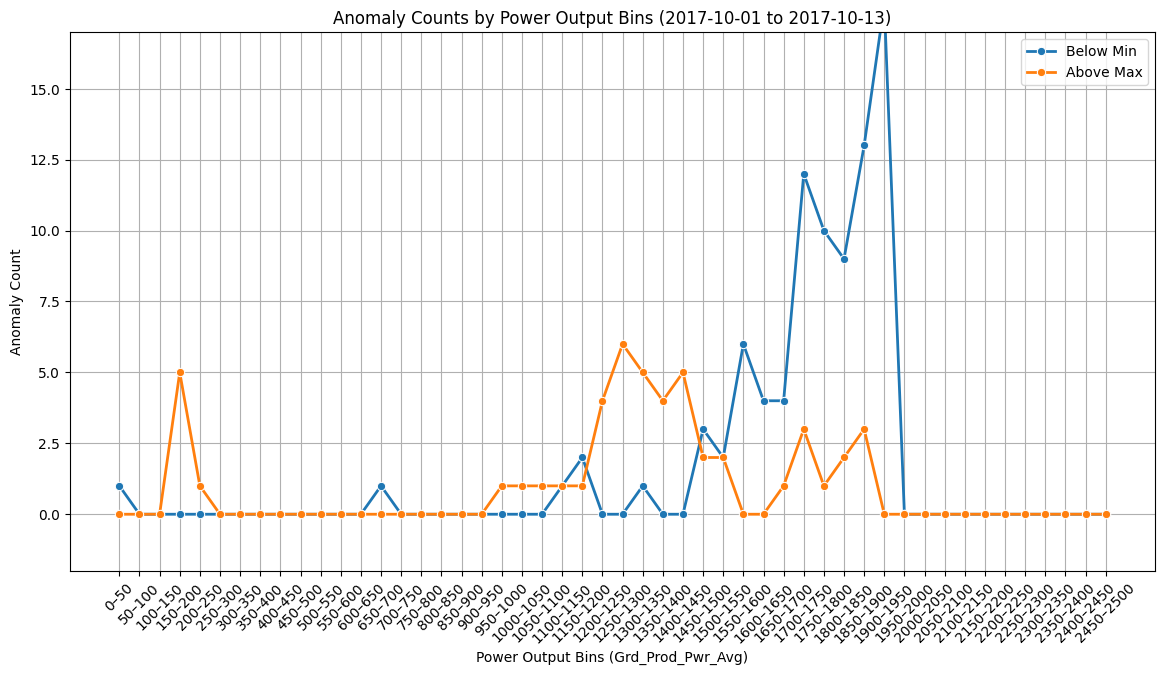

In [374]:
# Time filter
start_date = "2017-10-01"
end_date = "2017-10-13"
time_filtered_df = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= start_date) &
    (merged_df_filtered17_sorted["Timestamp"] <= end_date)
]

# Ensure power_bin column exists
time_filtered_df["power_bin"] = pd.cut(time_filtered_df[target_column], bins=range(0, 2501, 50))

# Step 1: Group and reset
anomaly_counts = time_filtered_df.groupby("power_bin")[["below_min", "above_max"]].sum()
anomaly_counts_reset = anomaly_counts.reset_index()

# Step 2: Convert bin to label
anomaly_counts_reset["power_bin_str"] = anomaly_counts_reset["power_bin"].apply(lambda x: f"{int(x.left)}–{int(x.right)}")

# Step 3: Plot
plt.figure(figsize=(14, 7))
sns.lineplot(x="power_bin_str", y="below_min", data=anomaly_counts_reset, marker="o", linewidth=2, label="Below Min")
sns.lineplot(x="power_bin_str", y="above_max", data=anomaly_counts_reset, marker="o", linewidth=2, label="Above Max")

plt.xlabel("Power Output Bins (Grd_Prod_Pwr_Avg)")
plt.ylabel("Anomaly Count")
plt.title(f"Anomaly Counts by Power Output Bins ({start_date} to {end_date})")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.ylim(-2, 17)
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_30428\1669424083.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("power_bin")["abs_residual"]
C:\Users\thors\AppData\Local\Temp\ipykernel_30428\1669424083.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("pred_bin")["modeling_spread"]


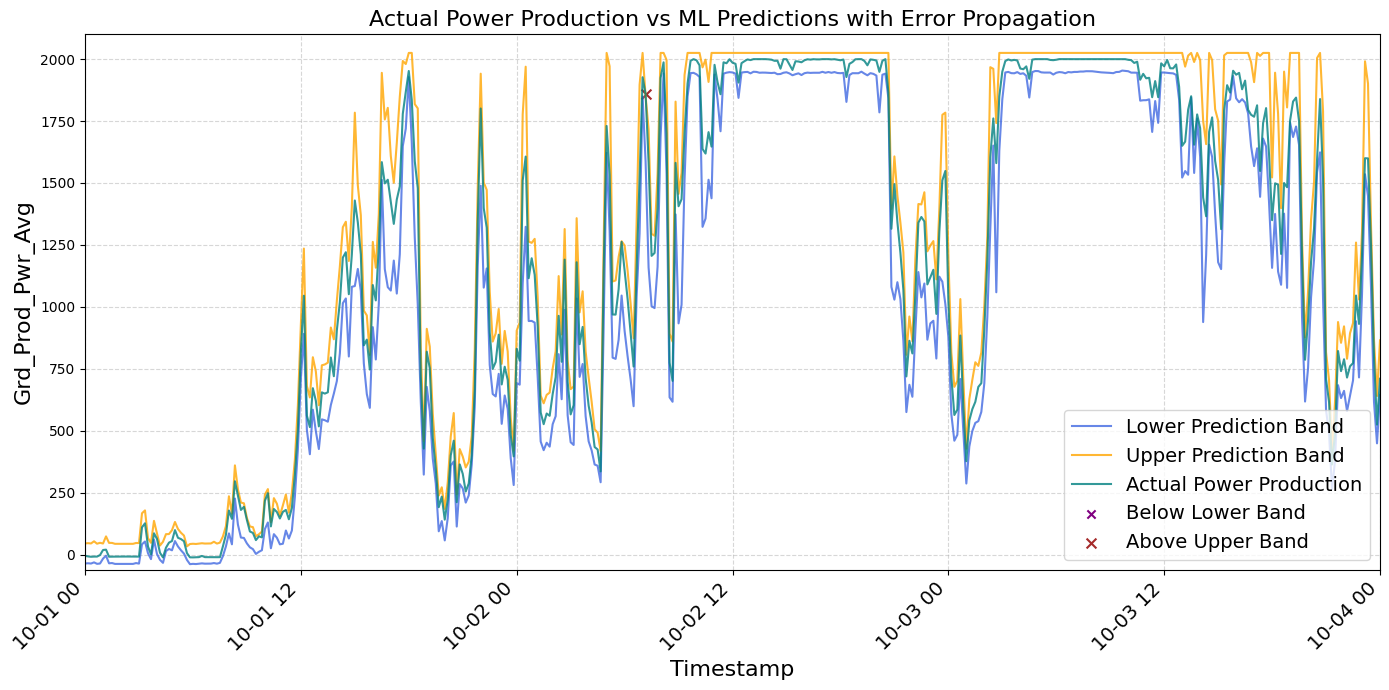

In [391]:
# 1. Define the inference period (timezone-aware)
inference_start = pd.to_datetime("2017-10-13").tz_localize("UTC")
inference_end   = pd.to_datetime("2017-11-05").tz_localize("UTC")

# 2. Filter the data for inference period
inference_df = merged_df_filtered17_sorted.loc[
    (merged_df_filtered17_sorted["Timestamp"] >= inference_start) &
    (merged_df_filtered17_sorted["Timestamp"] <= inference_end)
].copy()

# this is to be able to rerun. resets the p95 part
cols_to_drop = [
    "power_bin", "pred_bin", 
    "mean_error", "p5_error", "p95_error", 
    "mean_spread", "p5_spread", "p95_spread",
    "row_min", "row_max", 
    "below_min", "above_max"
]

merged_df_filtered17_sorted = merged_df_filtered17_sorted.drop(
    columns=[col for col in cols_to_drop if col in merged_df_filtered17_sorted.columns],
    errors='ignore'
)


# 3. Compute modeling_spread in inference data
inference_df["modeling_spread"] = (
    inference_df[prediction_columns].max(axis=1)
  - inference_df[prediction_columns].min(axis=1)
)

# 4. Determine bin edges based on inference data only
bin_width  = 50
min_val    = inference_df[[target_column, "xgboost_pred_2017"]].min().min()
max_val    = inference_df[[target_column, "xgboost_pred_2017"]].max().max()
min_power  = int(np.floor(min_val  / bin_width) * bin_width)
max_power  = int(np.ceil (max_val  / bin_width) * bin_width)
bin_edges  = np.arange(min_power, max_power + bin_width, bin_width)

# 5. Bin actual and predicted values in both datasets using those edges
for df in (merged_df_filtered17_sorted, inference_df):
    df["power_bin"] = pd.cut(df[target_column], bins=bin_edges, include_lowest=True)
    df["pred_bin"]  = pd.cut(df["xgboost_pred_2017"], bins=bin_edges, include_lowest=True)



# 6. Compute residual error stats (abs_residual) for each actual-power bin
bin_error_stats = (
    inference_df
      .groupby("power_bin")["abs_residual"]
      .agg(
          mean_error="mean",
          p5_error=lambda x: x.quantile(0.05),
          p95_error=lambda x: x.quantile(0.95)
      )
      .reset_index()
)

# 7. Compute modeling-spread stats for each predicted-power bin
modeling_error_stats = (
    inference_df
      .groupby("pred_bin")["modeling_spread"]
      .agg(
          mean_spread="mean",
          p5_spread=lambda x: x.quantile(0.05),
          p95_spread=lambda x: x.quantile(0.95)
      )
      .reset_index()
)

# 8. Merge stats back into the full dataset
# 8. Merge stats back into the full dataset (directly modify merged_df_filtered17_sorted)
merged_df_filtered17_sorted = (
    merged_df_filtered17_sorted
      .merge(bin_error_stats,    on="power_bin", how="left")
      .merge(modeling_error_stats, on="pred_bin", how="left")
)



# Calculate row_min and row_max using LINEAR SUM of bin-based modeling spread and residual error
"""merged_df_filtered17_sorted["row_min"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"] -
    (
        (merged_df_filtered17_sorted["mean_spread"] / 2) + 
        merged_df_filtered17_sorted["mean_error"]
    )
)

merged_df_filtered17_sorted["row_max"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"] +
    (
        (merged_df_filtered17_sorted["mean_spread"] / 2) + 
        merged_df_filtered17_sorted["mean_error"]
    )
)"""


#linear with absolute error
"""merged_df_filtered17_sorted["row_min"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"] -
    (
        np.abs(merged_df_filtered17_sorted["xgboost_pred_2017"] - merged_df_filtered17_sorted[prediction_columns].min(axis=1)) +
        np.abs(merged_df_filtered17_sorted["mean_error"])
    )
)

merged_df_filtered17_sorted["row_max"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"] +
    (
        np.abs(merged_df_filtered17_sorted[prediction_columns].max(axis=1) - merged_df_filtered17_sorted["xgboost_pred_2017"]) +
        np.abs(merged_df_filtered17_sorted["mean_error"])
    )
)"""

# RSS with absoulte
merged_df_filtered17_sorted["row_min"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"] -
    np.sqrt(
        np.abs(merged_df_filtered17_sorted["xgboost_pred_2017"] - merged_df_filtered17_sorted[prediction_columns].min(axis=1))**2 +
        np.abs(merged_df_filtered17_sorted["p95_error"])**2
    )
)

merged_df_filtered17_sorted["row_max"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"] +
    np.sqrt(
        np.abs(merged_df_filtered17_sorted[prediction_columns].max(axis=1) - merged_df_filtered17_sorted["xgboost_pred_2017"])**2 +
        np.abs(merged_df_filtered17_sorted["p95_error"])**2
    )
)


# Interval only
"""merged_df_filtered17_sorted["row_min"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"] -
    np.abs(merged_df_filtered17_sorted["xgboost_pred_2017"] - merged_df_filtered17_sorted[prediction_columns].min(axis=1))
)

merged_df_filtered17_sorted["row_max"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"] +
    np.abs(merged_df_filtered17_sorted[prediction_columns].max(axis=1) - merged_df_filtered17_sorted["xgboost_pred_2017"])
)"""

# Modelling error only
"""merged_df_filtered17_sorted["row_min"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"] - np.abs(merged_df_filtered17_sorted["mean_error"])
)

merged_df_filtered17_sorted["row_max"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"] + np.abs(merged_df_filtered17_sorted["mean_error"])
)"""


# lets clip the max to a certain value so we dont get predictions over the limit
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted["row_max"].clip(upper=2025)


# Flag where actual values are outside the row-wise min and max
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["row_min"]
).astype(int)

merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["row_max"]
).astype(int)

# Plot actual, prediction bands, and outliers
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["row_min"],
    color='royalblue', alpha=0.8, label='Lower Prediction Band', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["row_max"],
    color='orange', alpha=0.8, label='Upper Prediction Band', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted[target_column],
    color='teal', alpha=0.8, label='Actual Power Production', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label='Below Lower Band'
)

# Scatter points where actual is above row_max
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label='Above Upper Band'
)

# Clean up plot
plt.xticks(rotation=45, ha='right',fontsize=14)
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-04'))
plt.title("Actual Power Production vs ML Predictions with Error Propagation", fontsize=16)
plt.xlabel("Timestamp", fontsize=16)
plt.ylabel(target_column, fontsize=16)
plt.legend(fontsize=14)
plt.ylim(-60, 2100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

C:\Users\thors\AppData\Local\Temp\ipykernel_30428\2812201068.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_error_by_bin = merged_df_filtered17_sorted.groupby("power_bin")["abs_residual"].mean()


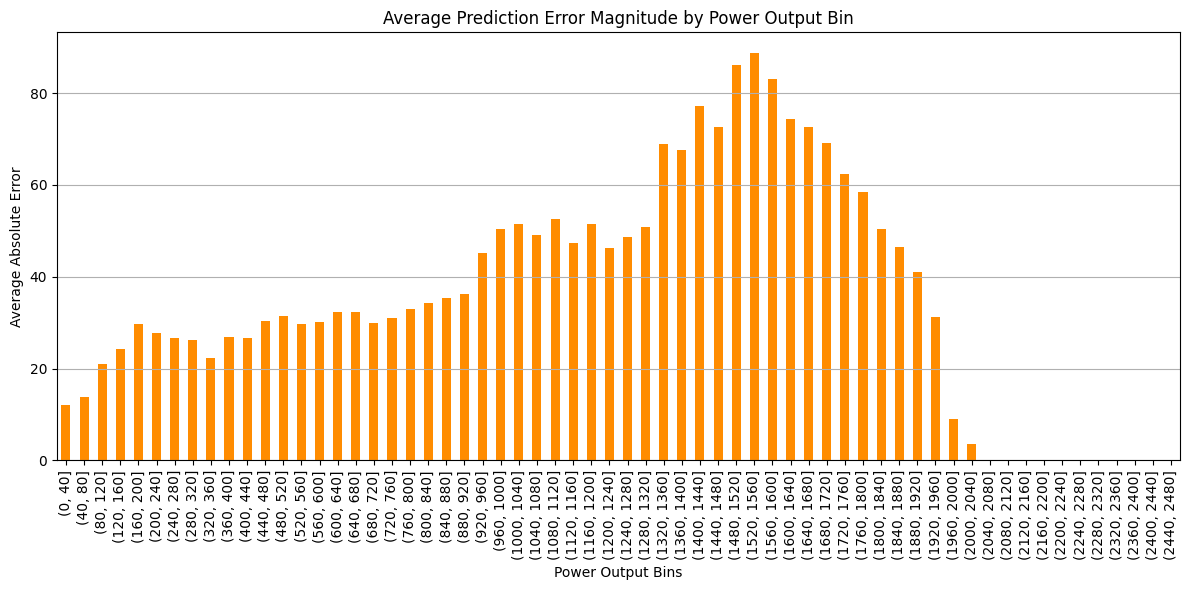

In [376]:
# Bin power output (e.g., 50 kW bins)
merged_df_filtered17_sorted["power_bin"] = pd.cut(
    merged_df_filtered17_sorted[target_column], bins=range(0, 2501,40)
)

# Compute absolute residuals if not already done
merged_df_filtered17_sorted["abs_residual"] = (
    merged_df_filtered17_sorted["residual"].abs()
)

# Group by power bin and calculate mean error
avg_error_by_bin = merged_df_filtered17_sorted.groupby("power_bin")["abs_residual"].mean()

# Plot
plt.figure(figsize=(12, 6))
avg_error_by_bin.plot(kind='bar', color='darkorange')
plt.xlabel("Power Output Bins")
plt.ylabel("Average Absolute Error")
plt.title("Average Prediction Error Magnitude by Power Output Bin")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_30428\2908255443.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_df["power_bin"] = pd.cut(time_filtered_df[target_column], bins=range(0, 2501, 50))
C:\Users\thors\AppData\Local\Temp\ipykernel_30428\2908255443.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  anomaly_counts = time_filtered_df.groupby("power_bin")[["below_min", "above_max"]].sum()


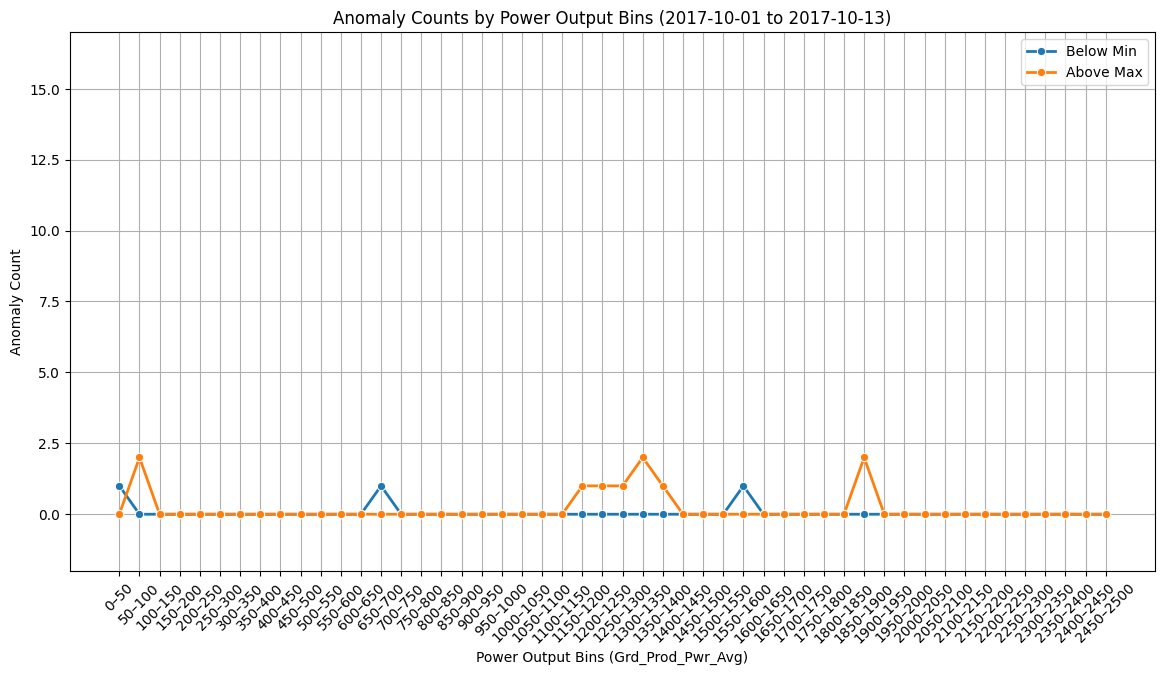

In [382]:
# Time filter
start_date = "2017-10-01"
end_date = "2017-10-13"
time_filtered_df = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= start_date) &
    (merged_df_filtered17_sorted["Timestamp"] <= end_date)
]

# Ensure power_bin column exists
time_filtered_df["power_bin"] = pd.cut(time_filtered_df[target_column], bins=range(0, 2501, 50))

# Step 1: Group and reset
anomaly_counts = time_filtered_df.groupby("power_bin")[["below_min", "above_max"]].sum()
anomaly_counts_reset = anomaly_counts.reset_index()

# Step 2: Convert bin to label
anomaly_counts_reset["power_bin_str"] = anomaly_counts_reset["power_bin"].apply(lambda x: f"{int(x.left)}–{int(x.right)}")

# Step 3: Plot
plt.figure(figsize=(14, 7))
sns.lineplot(x="power_bin_str", y="below_min", data=anomaly_counts_reset, marker="o", linewidth=2, label="Below Min")
sns.lineplot(x="power_bin_str", y="above_max", data=anomaly_counts_reset, marker="o", linewidth=2, label="Above Max")

plt.xlabel("Power Output Bins (Grd_Prod_Pwr_Avg)")
plt.ylabel("Anomaly Count")
plt.title(f"Anomaly Counts by Power Output Bins ({start_date} to {end_date})")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.ylim(-2, 17)
plt.show()


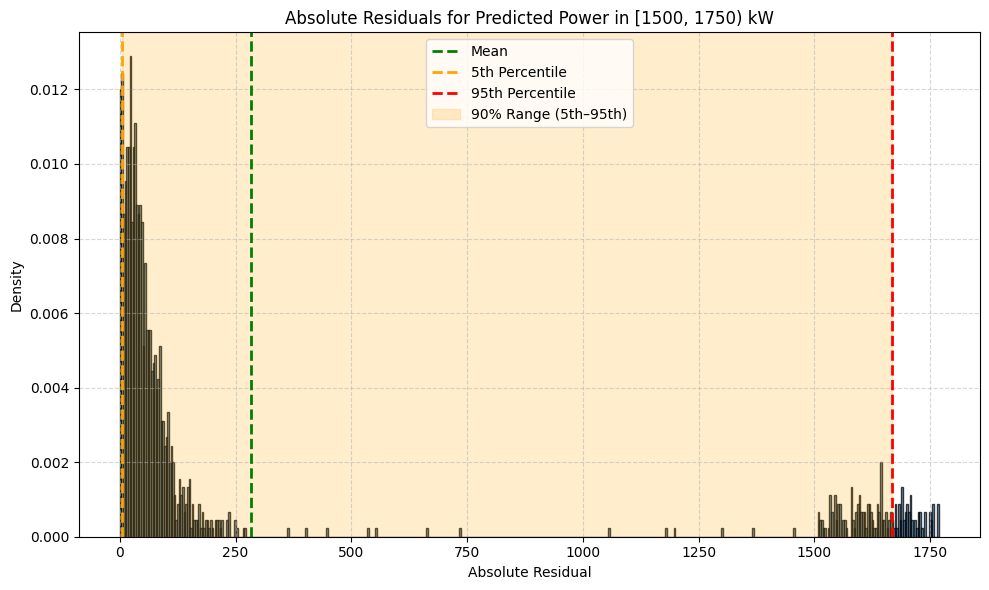

In [378]:
# Manually define bin range (e.g., 1650 to 1670 kW)
bin_lower = 1500
bin_upper = 1750

# Filter rows where predicted power falls into the selected bin range
selected_bin_data = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["xgboost_pred_2017"] >= bin_lower) &
    (merged_df_filtered17_sorted["xgboost_pred_2017"] < bin_upper)
]

# Extract absolute residuals
abs_residuals = selected_bin_data["abs_residual"]

# Compute statistics
mean_abs = abs_residuals.mean()
p5_abs = abs_residuals.quantile(0.05)
p95_abs = abs_residuals.quantile(0.95)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(abs_residuals, bins=500, alpha=0.75, color='steelblue', edgecolor='black', density=True)

# Mark key thresholds
plt.axvline(mean_abs, color='green', linestyle='--', linewidth=2, label='Mean')
plt.axvline(p5_abs, color='orange', linestyle='--', linewidth=2, label='5th Percentile')
plt.axvline(p95_abs, color='red', linestyle='--', linewidth=2, label='95th Percentile')
plt.axvspan(p5_abs, p95_abs, color='orange', alpha=0.2, label='90% Range (5th–95th)')

# Add plot labels and styling
plt.title(f"Absolute Residuals for Predicted Power in [{bin_lower}, {bin_upper}) kW")
plt.xlabel("Absolute Residual")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [379]:
# Define time window
start_time = pd.to_datetime('2017-10-01').tz_localize('UTC')
end_time = pd.to_datetime('2017-10-04').tz_localize('UTC')

# Filter data to that time window
subset = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= start_time) &
    (merged_df_filtered17_sorted["Timestamp"] <= end_time)
].copy()

# Compute interval width in the subset
subset["interval_width"] = subset["row_max"] - subset["row_min"]

# Compute total interval width and anomalies
total_interval_width = subset["interval_width"].sum()
total_anomalies = subset["above_max"].sum() + subset["below_min"].sum()
total_points = len(subset)
successful_predictions = total_points - total_anomalies

# Avoid division by zero
reliability_efficiency_score = (
    successful_predictions / total_interval_width
    if total_interval_width > 0 else np.nan
)

print(f"Reliability-Efficiency Score ({start_time.date()} to {end_time.date()}): {reliability_efficiency_score:.4f}")


Reliability-Efficiency Score (2017-10-01 to 2017-10-04): 0.0045


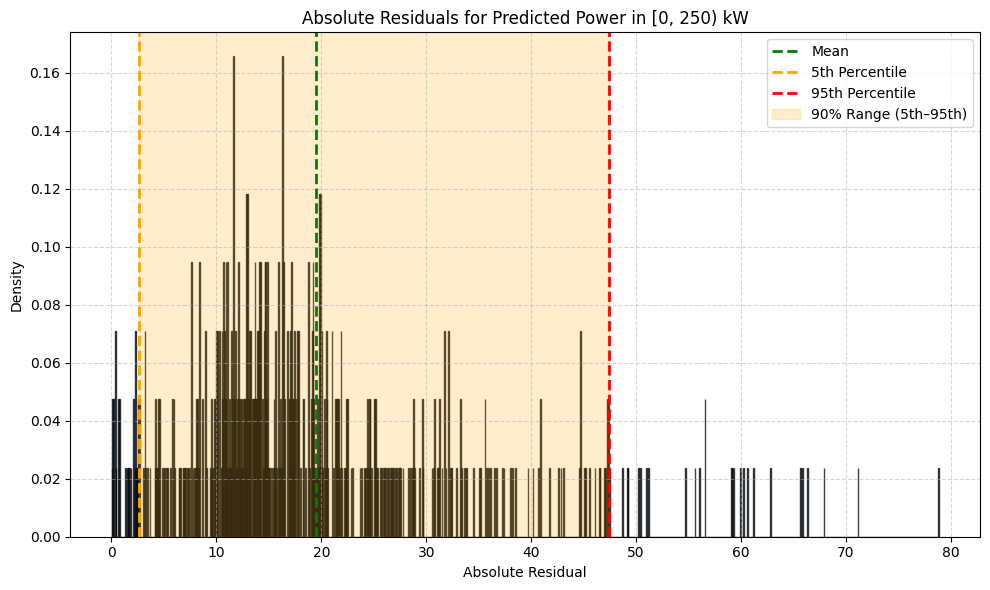

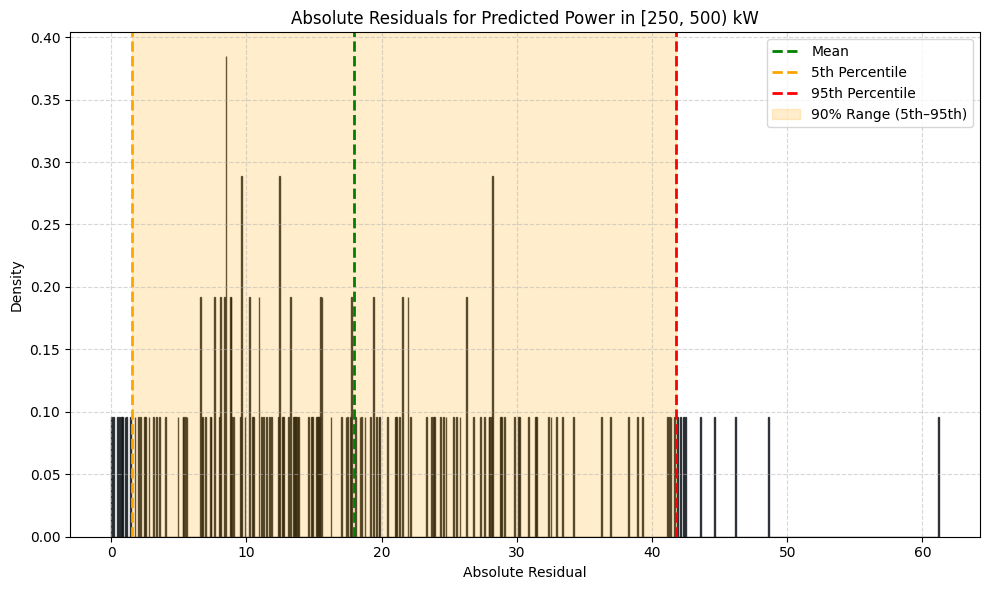

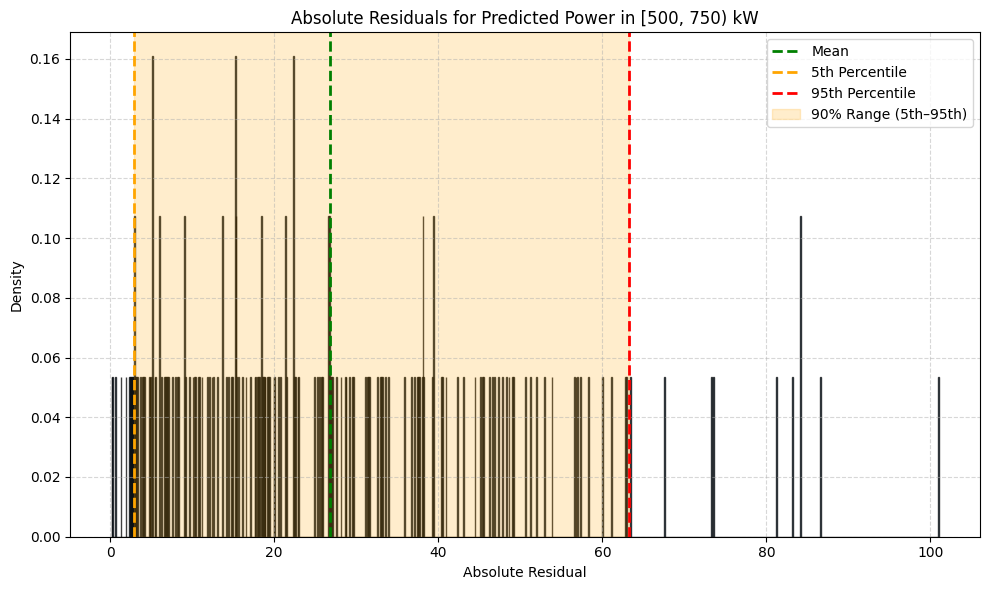

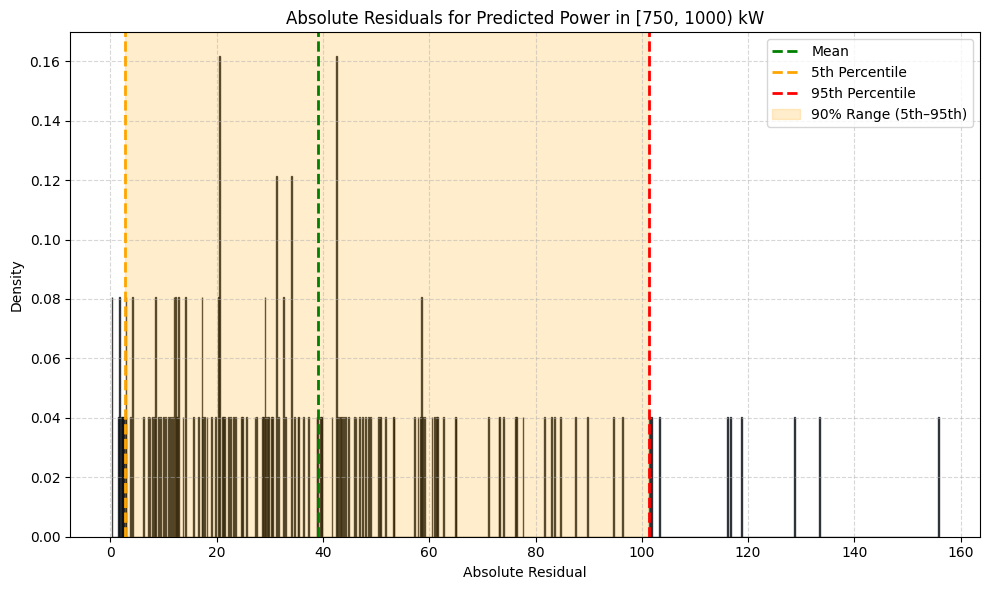

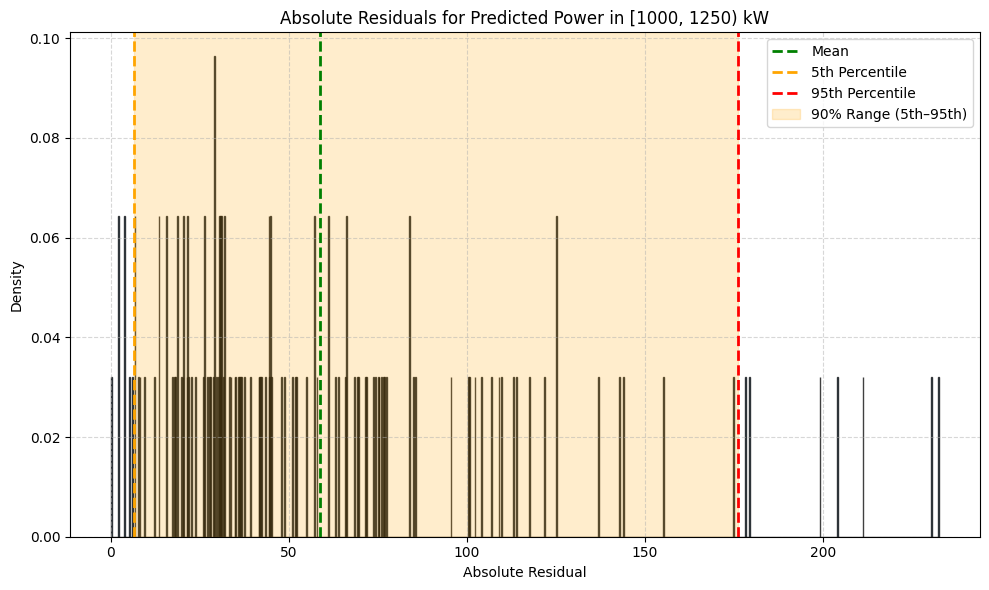

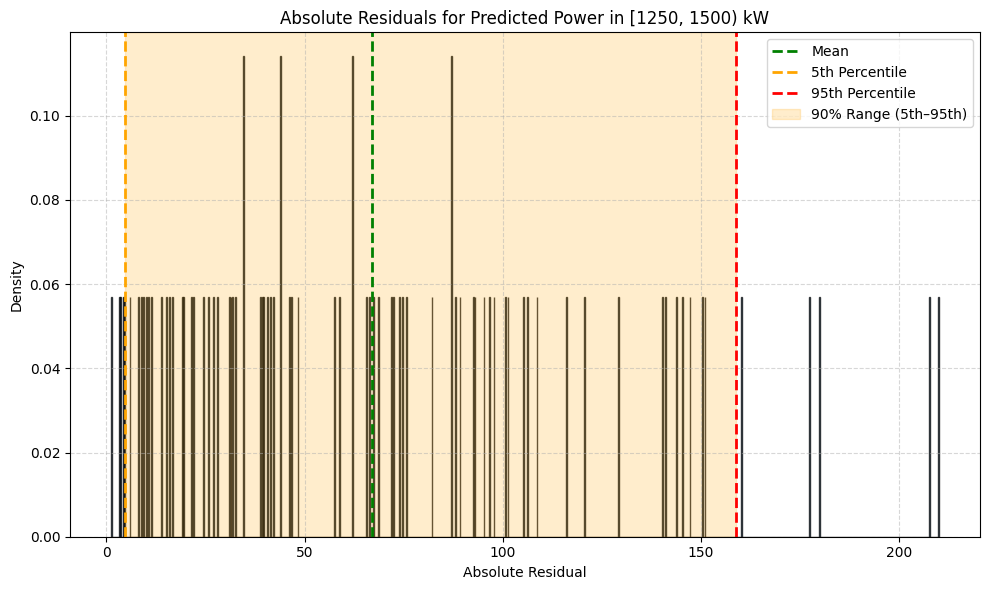

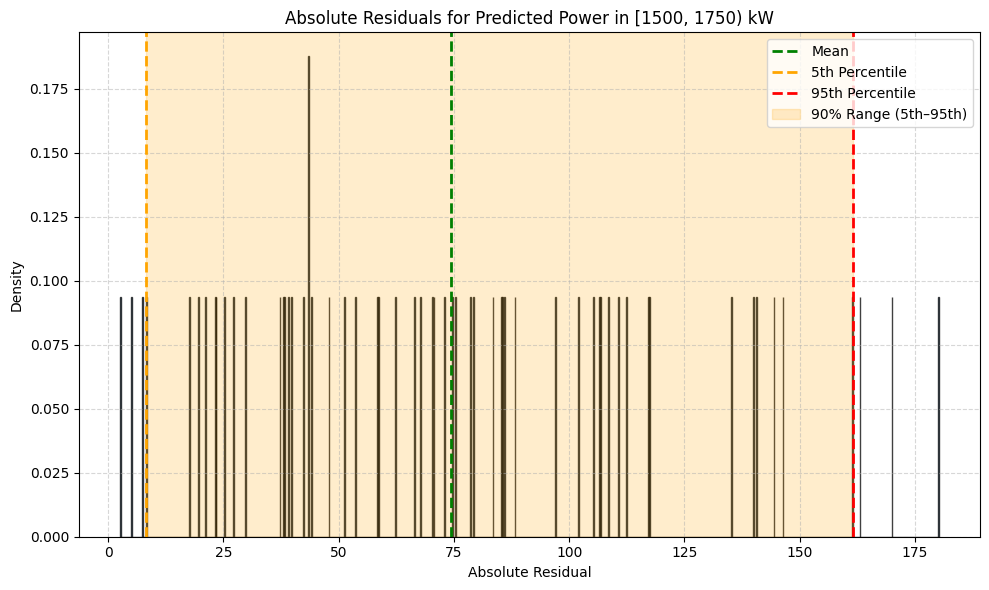

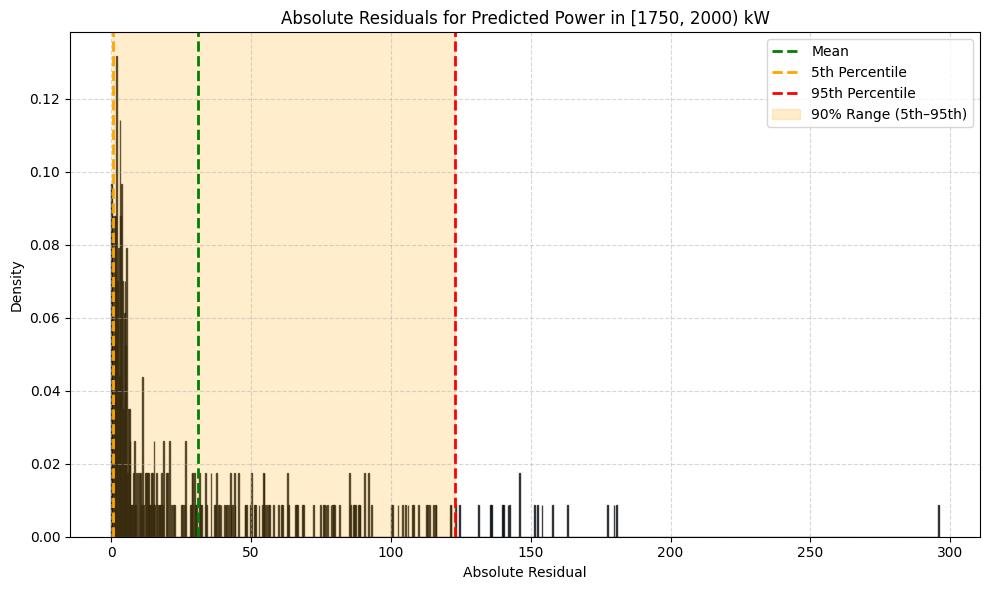

In [380]:
start_date = pd.to_datetime('2017-10-01').tz_localize('UTC')
end_date = pd.to_datetime('2017-10-13').tz_localize('UTC')

# 2. Define manually adjustable bin range for predicted power (0 to 2000 kW, in steps of 100 kW)
bin_width = 250
bin_edges = range(0, 2001, bin_width)  # Bins from 0 to 2000 kW

# 3. Filter data within the selected date range
filtered_data = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= start_date) & 
    (merged_df_filtered17_sorted["Timestamp"] <= end_date)
].copy()

# 4. Loop through each bin range (e.g., 0-100 kW, 100-200 kW, etc.)
for bin_lower in bin_edges[:-1]:
    bin_upper = bin_lower + bin_width
    
    # 5. Filter rows where predicted power falls into the selected bin range
    selected_bin_data = filtered_data[
        (filtered_data["xgboost_pred_2017"] >= bin_lower) & 
        (filtered_data["xgboost_pred_2017"] < bin_upper)
    ]

    # Skip empty bins
    if selected_bin_data.empty:
        continue
    
    # 6. Extract absolute residuals
    abs_residuals = selected_bin_data["abs_residual"]
    
    # 7. Compute statistics
    mean_abs = abs_residuals.mean()
    p5_abs = abs_residuals.quantile(0.05)
    p95_abs = abs_residuals.quantile(0.95)
    
    # 8. Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(abs_residuals, bins=1000, alpha=0.75, color='steelblue', edgecolor='black', density=True)

    # Mark key thresholds
    plt.axvline(mean_abs, color='green', linestyle='--', linewidth=2, label='Mean')
    plt.axvline(p5_abs, color='orange', linestyle='--', linewidth=2, label='5th Percentile')
    plt.axvline(p95_abs, color='red', linestyle='--', linewidth=2, label='95th Percentile')
    plt.axvspan(p5_abs, p95_abs, color='orange', alpha=0.2, label='90% Range (5th–95th)')
    
    # Add plot labels and styling
    plt.title(f"Absolute Residuals for Predicted Power in [{bin_lower}, {bin_upper}) kW")
    plt.xlabel("Absolute Residual")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


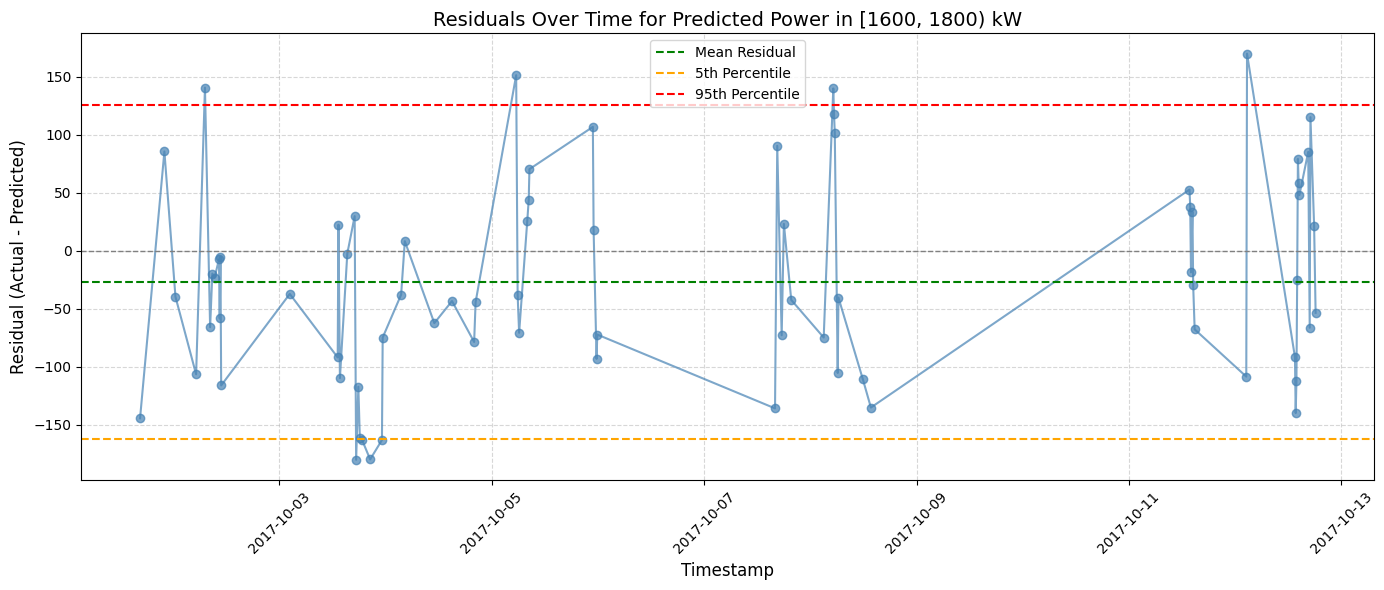

In [381]:
start_date = pd.to_datetime('2017-10-01').tz_localize('UTC')
end_date = pd.to_datetime('2017-10-13').tz_localize('UTC')

# 2. Define manually adjustable bin range for predicted power (e.g., 1300 to 1800 kW)
bin_lower = 1600
bin_upper = 1800

# 3. Filter data within the selected date range
filtered_data = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= start_date) & 
    (merged_df_filtered17_sorted["Timestamp"] <= end_date)
].copy()

# 4. Filter data within the selected predicted power bin range
selected_bin_data = filtered_data[
    (filtered_data["xgboost_pred_2017"] >= bin_lower) & 
    (filtered_data["xgboost_pred_2017"] < bin_upper)
].copy()

# 5. Exclude zero or near-zero actual power (e.g., < 100 kW)
selected_bin_data = selected_bin_data[selected_bin_data["Grd_Prod_Pwr_Avg"] > 100]

# 6. Compute absolute residuals
selected_bin_data["residual"] = (
    selected_bin_data["Grd_Prod_Pwr_Avg"].abs() - selected_bin_data["xgboost_pred_2017"].abs()
)

# 7. Plot residuals over time
plt.figure(figsize=(14, 6))
plt.plot(selected_bin_data["Timestamp"], selected_bin_data["residual"], marker='o', linestyle='-', color='steelblue', alpha=0.7)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Highlight mean and percentiles
mean_resid = selected_bin_data["residual"].mean()
p5_resid = selected_bin_data["residual"].quantile(0.05)
p95_resid = selected_bin_data["residual"].quantile(0.95)

plt.axhline(mean_resid, color='green', linestyle='--', label='Mean Residual')
plt.axhline(p5_resid, color='orange', linestyle='--', label='5th Percentile')
plt.axhline(p95_resid, color='red', linestyle='--', label='95th Percentile')

# Plot styling
plt.title(f"Residuals Over Time for Predicted Power in [{bin_lower}, {bin_upper}) kW", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Residual (Actual - Predicted)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
